In [0]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17598554530225142938, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 9164553878614632035
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
!pip install --upgrade gensim
from gensim.models.word2vec import Word2VecKeyedVectors

  Using cached gensim-3.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached scipy-1.0.0-cp36-cp36m-manylinux1_x86_64.whl
Requirement already up-to-date: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim)
  Using cached numpy-1.14.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached smart_open-1.5.6.tar.gz
  Using cached boto3-1.6.9-py2.py3-none-any.whl
  Using cached boto-2.48.0-py2.py3-none-any.whl
  Using cached bz2file-0.98.tar.gz
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
  Using cached botocore-1.9.9.tar.gz
    100% |████████████████████████████████| 61kB 2.6MB/s 
Requirement already up-to-date: idna<2.7,>=2.5 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim)
Requirement already up-to-date: certifi>=2017.4.17 in /usr/local/li

      Successfully uninstalled scipy-0.19.1
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3


In [4]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
file_id_data= json.loads(uploaded['file_id.json'])

Saving file_id.json to file_id.json
User uploaded file "file_id.json" with length 489 bytes


In [0]:
#2. Get the files
downloaded1 = drive.CreateFile({'id':file_id_data["modified_train_file_id"]}) 
downloaded1.GetContentFile('modified_train_data.csv')  
downloaded2 = drive.CreateFile({'id':file_id_data["modified_test_file_id"]}) 
downloaded2.GetContentFile('modified_test_data.csv')
downloaded3 = drive.CreateFile({'id':file_id_data["word2vec_model"]}) 
downloaded3.GetContentFile('word2vec_model')  
downloaded4 = drive.CreateFile({'id':file_id_data["data"]}) 
downloaded4.GetContentFile('data.json')

In [0]:
#3. Read file as panda dataframe
data = pd.read_csv('modified_train_data.csv') 
test_data = pd.read_csv('modified_test_data.csv')

In [0]:
os.remove("modified_train_data.csv")
os.remove("modified_test_data.csv")

In [0]:
metadata= json.loads(open("data.json").read())
size = metadata['size']

In [0]:
fname = "word2vec_model"
model = Word2VecKeyedVectors.load_word2vec_format(fname)

In [0]:
os.remove("word2vec_model")

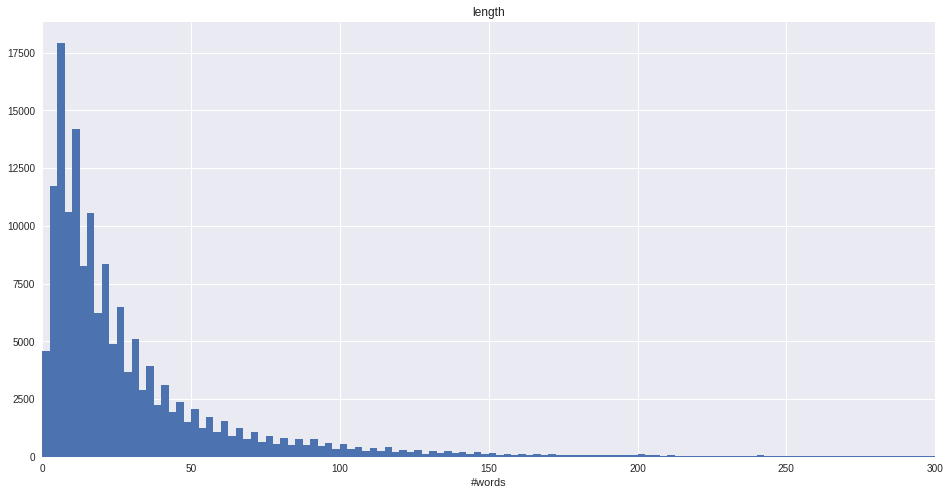

In [13]:
data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

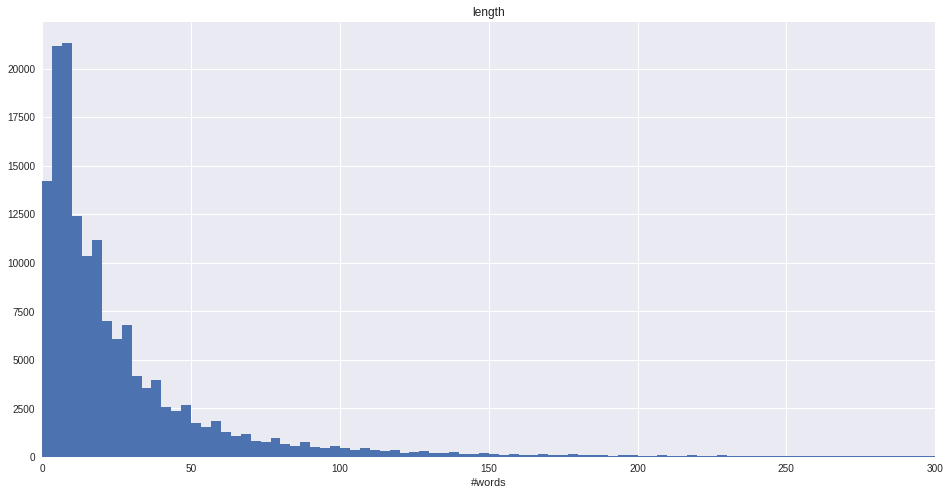

In [14]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

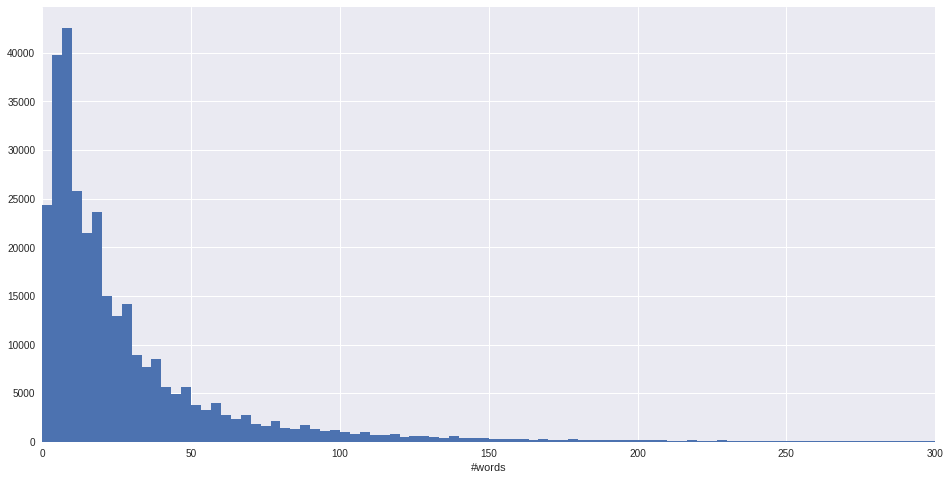

In [15]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.xlim(0,300)
plt.xlabel("#words")
plt.show()
del(all_length)

In [0]:
comments = data["comment_text"].as_matrix()
sentiments = data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].as_matrix()
seq_length = data['length'].as_matrix()

train_indices = np.random.choice(len(seq_length), round(len(seq_length)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(seq_length))) - set(train_indices)))

comments_train = comments[train_indices]
comments_validation = comments[validation_indices]
comments_test = test_data["comment_text"].as_matrix()

seq_length_train = seq_length[train_indices]
seq_length_validation = seq_length[validation_indices]
seq_length_test = test_data['length'].as_matrix()

sentiments_train = sentiments[train_indices]
sentiments_validation = sentiments[validation_indices]

test_id = test_data['id'].as_matrix()

In [17]:
print("shape of comments_train:",comments_train.shape)
print("shape of comments_validation:",comments_validation.shape)
print("shape of comments_test:",comments_test.shape)
print("shape of seq_length_train:",seq_length_train.shape)
print("shape of seq_length_validation:",seq_length_validation.shape)
print("shape of seq_length_test:",seq_length_test.shape)
print("shape of sentiments_train:",sentiments_train.shape)
print("shape of sentiments_test:",sentiments_validation.shape)
print("shape of test_id:",test_id.shape)

shape of comments_train: (153188,)
shape of comments_validation: (6383,)
shape of comments_test: (153164,)
shape of seq_length_train: (153188,)
shape of seq_length_validation: (6383,)
shape of seq_length_test: (153164,)
shape of sentiments_train: (153188, 6)
shape of sentiments_test: (6383, 6)
shape of test_id: (153164,)


In [0]:
del(train_indices, validation_indices, data, test_data, comments, sentiments, seq_length)

In [0]:
def sequence_generator(comments, max_length, size):
    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

In [0]:
max_length = n_steps =250 
size = n_inputs = size
n_outputs = 6

In [0]:
def generate_train_batch(indices, comments, seq_length, sentiments, max_length, size):
    
    comments_batch = comments[indices]
    seq_length_batch = seq_length[indices]
    sentiments_batch = sentiments[indices]
    
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    return sequences_batch, seq_length_batch, sentiments_batch

In [0]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
labels = tf.placeholder(tf.float32, [None, n_outputs])
length = tf.placeholder(tf.int32, [None])
keep_prob = tf.placeholder(tf.float32)

In [0]:
n_layers = 3
n_neurons = 128

In [0]:
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
lstm_cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
                    for cell in lstm_cells]
cells_across_gpu = [tf.contrib.rnn.DeviceWrapper("/device:GPU:0", cell) for cell in lstm_cells_drop]

multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

In [25]:
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32, sequence_length=length)
top_layer_h_state = states[-1][1]
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 128) dtype=float32>

In [0]:
def create_weights(shape):
    '''a function to create weight tensor'''
    with tf.device("/device:CPU:0"):
      W = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    return W

def create_biases(size):
    '''a function to create bias tensor'''
    with tf.device("/device:CPU:0"):
      b = tf.Variable(tf.constant(0.05, shape=[size]))
    return b

In [0]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=False,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    with tf.device("/device:GPU:0"):
      # matrix multiplication between input and weight matrix
      layer = tf.matmul(input, weights)

      # add the bias to the convolutional layer
      layer += biases

      # add relu activation if wanted
      if use_relu:
          layer = tf.nn.relu(layer)

      # if dropout is wanted add dropout
      if dropout:        
          layer = tf.nn.dropout(layer, keep_prob)

    # return layer
    return layer

In [0]:
fc_layer_size1 = 32
# fc_layer_size2 = 64

In [29]:
layer_fc1 = create_fc_layer(input=top_layer_h_state,
                            num_inputs=top_layer_h_state.get_shape()[1].value,
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout =True,
                            keep_prob = keep_prob)
layer_fc1

<tf.Tensor 'dropout/mul:0' shape=(?, 32) dtype=float32>

In [0]:
# layer_fc2 = create_fc_layer(input=layer_fc1,
#                             num_inputs=fc_layer_size1,
#                             num_outputs=fc_layer_size2,
#                             use_relu=True,
#                             dropout =True,
#                             keep_prob = keep_prob)
# layer_fc2

In [31]:
output = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=n_outputs,
                            use_relu=False,
                            dropout =False)
output

<tf.Tensor 'add_1:0' shape=(?, 6) dtype=float32>

In [32]:
with tf.device("/device:GPU:0"):
  logits = tf.nn.sigmoid(output)
logits

<tf.Tensor 'Sigmoid:0' shape=(?, 6) dtype=float32>

In [0]:
with tf.device("/device:GPU:0"):
  loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=output)

In [0]:
roc = tf.metrics.auc(labels=labels, predictions=logits)

In [0]:
# learning rate of optimizer
learning_rate = (1e-3)*6
with tf.device("/device:GPU:0"):
  # train step
  train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [0]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []
valid_roc = []

# batch size
batch_size = 200
# max iteration
max_iter = 3000

In [37]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_accuracy = 0
best_roc = -10
best_iteration = None

iteration = 0

train_hours = 4

# feed dictionary for validation
feed_dict_validation =  {X:sequence_generator(comments_validation, max_length, size),
                        labels:sentiments_validation,
                        length:seq_length_validation,
                        keep_prob: 1.0}

t1 = time.time()

# create a graph session and optimize under it
with tf.Session() as sess:
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # while minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < train_hours*60*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(sentiments_train.shape[0], size=batch_size)

        # extract the batch data
        sequences_batch, seq_length_batch, sentiments_batch = \
        generate_train_batch(rand_index, comments_train, seq_length_train, sentiments_train,
                             max_length, size)
        
        # feed dictionary for batch
        feed_dict_batch =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 0.75}
        # feed dictionary for train
        feed_dict_train =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 1.0}        
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)

        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # calculate roc score
        temp_roc_score = sess.run(roc, feed_dict=feed_dict_validation)[1]
        valid_roc.append(temp_roc_score)
        
        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_roc_score > best_roc:
            best_roc = temp_roc_score
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)

        # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| Roc Score:", temp_roc_score,
              "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))
        
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 0.68478346 | validation_loss: 0.68602 | Roc Score: 0.71737707 | Time elapsed: 0:00:05.751477
iterations: 1 | train_loss: 0.580639 | validation_loss: 0.58670264 | Roc Score: 0.6343635 | Time elapsed: 0:00:10.817019
iterations: 2 | train_loss: 0.46828642 | validation_loss: 0.4678151 | Roc Score: 0.613758 | Time elapsed: 0:00:15.903695
iterations: 3 | train_loss: 0.3265484 | validation_loss: 0.33427298 | Roc Score: 0.5959931 | Time elapsed: 0:00:20.978387
iterations: 4 | train_loss: 0.20930286 | validation_loss: 0.22391213 | Roc Score: 0.5813009 | Time elapsed: 0:00:26.075856
iterations: 5 | train_loss: 0.1583008 | validation_loss: 0.16211379 | Roc Score: 0.5712571 | Time elapsed: 0:00:31.149620
iterations: 6 | train_loss: 0.15508525 | validation_loss: 0.14535493 | Roc Score: 0.5642109 | Time elapsed: 0:00:36.265902
iterations: 7 | train_loss: 0.13316767 | validation_loss: 0.15361018 | Roc Score: 0.5582676 | Time elapsed: 0:00:41.332130
iterations: 8 | train_lo

iterations: 39 | train_loss: 0.15328509 | validation_loss: 0.13758427 | Roc Score: 0.6547593 | Time elapsed: 0:03:24.280307
iterations: 40 | train_loss: 0.14952433 | validation_loss: 0.13792019 | Roc Score: 0.65628934 | Time elapsed: 0:03:29.324511
iterations: 41 | train_loss: 0.15166746 | validation_loss: 0.13825081 | Roc Score: 0.65778214 | Time elapsed: 0:03:34.430378
iterations: 42 | train_loss: 0.13607079 | validation_loss: 0.13845533 | Roc Score: 0.65923953 | Time elapsed: 0:03:39.522282
iterations: 43 | train_loss: 0.15078084 | validation_loss: 0.1385146 | Roc Score: 0.66061544 | Time elapsed: 0:03:44.615411
iterations: 44 | train_loss: 0.13609357 | validation_loss: 0.13857788 | Roc Score: 0.66190076 | Time elapsed: 0:03:49.713071
iterations: 45 | train_loss: 0.16537581 | validation_loss: 0.13855274 | Roc Score: 0.6631329 | Time elapsed: 0:03:54.845357
iterations: 46 | train_loss: 0.15414922 | validation_loss: 0.13842753 | Roc Score: 0.66433364 | Time elapsed: 0:03:59.942408
ite

iterations: 78 | train_loss: 0.1438365 | validation_loss: 0.13632199 | Roc Score: 0.6937026 | Time elapsed: 0:06:42.344162
iterations: 79 | train_loss: 0.14400081 | validation_loss: 0.13626292 | Roc Score: 0.6943683 | Time elapsed: 0:06:47.397916
iterations: 80 | train_loss: 0.16785763 | validation_loss: 0.13626477 | Roc Score: 0.69503164 | Time elapsed: 0:06:52.438884
iterations: 81 | train_loss: 0.1678497 | validation_loss: 0.13648799 | Roc Score: 0.6956401 | Time elapsed: 0:06:57.557394
iterations: 82 | train_loss: 0.14183594 | validation_loss: 0.13685925 | Roc Score: 0.69624346 | Time elapsed: 0:07:02.632558
iterations: 83 | train_loss: 0.16918524 | validation_loss: 0.1375376 | Roc Score: 0.6968479 | Time elapsed: 0:07:07.693943
iterations: 84 | train_loss: 0.15886757 | validation_loss: 0.13828878 | Roc Score: 0.6974412 | Time elapsed: 0:07:12.775978
iterations: 85 | train_loss: 0.18313655 | validation_loss: 0.13921164 | Roc Score: 0.69799525 | Time elapsed: 0:07:17.876084
iteratio

iterations: 117 | train_loss: 0.1945413 | validation_loss: 0.13617605 | Roc Score: 0.71273756 | Time elapsed: 0:10:00.540710
iterations: 118 | train_loss: 0.1217346 | validation_loss: 0.13625546 | Roc Score: 0.71308327 | Time elapsed: 0:10:05.665417
iterations: 119 | train_loss: 0.14160714 | validation_loss: 0.1362947 | Roc Score: 0.71342117 | Time elapsed: 0:10:10.726750
iterations: 120 | train_loss: 0.10505302 | validation_loss: 0.1361705 | Roc Score: 0.7137467 | Time elapsed: 0:10:15.900588
iterations: 121 | train_loss: 0.111581564 | validation_loss: 0.13616091 | Roc Score: 0.7140553 | Time elapsed: 0:10:20.998902
iterations: 122 | train_loss: 0.14985976 | validation_loss: 0.13630328 | Roc Score: 0.7143526 | Time elapsed: 0:10:26.074446
iterations: 123 | train_loss: 0.12860371 | validation_loss: 0.13650878 | Roc Score: 0.7146499 | Time elapsed: 0:10:31.037816
iterations: 124 | train_loss: 0.15117182 | validation_loss: 0.13650747 | Roc Score: 0.7149375 | Time elapsed: 0:10:36.091236


iterations: 156 | train_loss: 0.097956315 | validation_loss: 0.13167708 | Roc Score: 0.72919613 | Time elapsed: 0:13:21.887800
iterations: 157 | train_loss: 0.25742206 | validation_loss: 0.13082014 | Roc Score: 0.72957873 | Time elapsed: 0:13:27.134927
iterations: 158 | train_loss: 0.12107765 | validation_loss: 0.12925215 | Roc Score: 0.7299662 | Time elapsed: 0:13:32.369935
iterations: 159 | train_loss: 0.13942541 | validation_loss: 0.12909305 | Roc Score: 0.73032874 | Time elapsed: 0:13:37.566826
iterations: 160 | train_loss: 0.15518244 | validation_loss: 0.13080992 | Roc Score: 0.73064435 | Time elapsed: 0:13:42.811068
iterations: 161 | train_loss: 0.1389669 | validation_loss: 0.13325818 | Roc Score: 0.73089945 | Time elapsed: 0:13:48.023118
iterations: 162 | train_loss: 0.16432007 | validation_loss: 0.13567084 | Roc Score: 0.7311159 | Time elapsed: 0:13:53.187566
iterations: 163 | train_loss: 0.15657656 | validation_loss: 0.13740541 | Roc Score: 0.7312558 | Time elapsed: 0:13:58.40

iterations: 195 | train_loss: 0.084567726 | validation_loss: 0.1122115 | Roc Score: 0.75211245 | Time elapsed: 0:16:44.728016
iterations: 196 | train_loss: 0.10945942 | validation_loss: 0.11080231 | Roc Score: 0.7530492 | Time elapsed: 0:16:49.905382
iterations: 197 | train_loss: 0.08903241 | validation_loss: 0.10873377 | Roc Score: 0.7539964 | Time elapsed: 0:16:55.130693
iterations: 198 | train_loss: 0.10733414 | validation_loss: 0.10737462 | Roc Score: 0.7549655 | Time elapsed: 0:17:00.338318
iterations: 199 | train_loss: 0.13539067 | validation_loss: 0.10751617 | Roc Score: 0.755911 | Time elapsed: 0:17:05.540389
iterations: 200 | train_loss: 0.08378206 | validation_loss: 0.10725788 | Roc Score: 0.75684744 | Time elapsed: 0:17:10.798568
iterations: 201 | train_loss: 0.084218524 | validation_loss: 0.106374525 | Roc Score: 0.75779986 | Time elapsed: 0:17:16.042545
iterations: 202 | train_loss: 0.1396496 | validation_loss: 0.103965074 | Roc Score: 0.7588108 | Time elapsed: 0:17:21.232

iterations: 234 | train_loss: 0.043309066 | validation_loss: 0.07780659 | Roc Score: 0.7910146 | Time elapsed: 0:20:07.918369
iterations: 235 | train_loss: 0.06411923 | validation_loss: 0.0770246 | Roc Score: 0.79201883 | Time elapsed: 0:20:13.077800
iterations: 236 | train_loss: 0.061592292 | validation_loss: 0.07605676 | Roc Score: 0.79302377 | Time elapsed: 0:20:18.306021
iterations: 237 | train_loss: 0.088243105 | validation_loss: 0.07527425 | Roc Score: 0.7940373 | Time elapsed: 0:20:23.503444
iterations: 238 | train_loss: 0.10162374 | validation_loss: 0.07477682 | Roc Score: 0.79504585 | Time elapsed: 0:20:28.746053
iterations: 239 | train_loss: 0.060179852 | validation_loss: 0.07460023 | Roc Score: 0.7960426 | Time elapsed: 0:20:33.926970
iterations: 240 | train_loss: 0.07576404 | validation_loss: 0.07450204 | Roc Score: 0.7970305 | Time elapsed: 0:20:39.147700
iterations: 241 | train_loss: 0.0840035 | validation_loss: 0.07339806 | Roc Score: 0.79802597 | Time elapsed: 0:20:44.3

iterations: 273 | train_loss: 0.04879298 | validation_loss: 0.06364931 | Roc Score: 0.82408637 | Time elapsed: 0:23:31.553370
iterations: 274 | train_loss: 0.07463176 | validation_loss: 0.063056774 | Roc Score: 0.82486886 | Time elapsed: 0:23:36.749241
iterations: 275 | train_loss: 0.04065178 | validation_loss: 0.06739701 | Roc Score: 0.8256142 | Time elapsed: 0:23:41.970149
iterations: 276 | train_loss: 0.055549763 | validation_loss: 0.07060529 | Roc Score: 0.82634 | Time elapsed: 0:23:47.200659
iterations: 277 | train_loss: 0.067222096 | validation_loss: 0.068623796 | Roc Score: 0.8270732 | Time elapsed: 0:23:52.392080
iterations: 278 | train_loss: 0.051623467 | validation_loss: 0.06342935 | Roc Score: 0.8278216 | Time elapsed: 0:23:57.625960
iterations: 279 | train_loss: 0.047201384 | validation_loss: 0.06554997 | Roc Score: 0.8284977 | Time elapsed: 0:24:02.872777
iterations: 280 | train_loss: 0.0613929 | validation_loss: 0.07009956 | Roc Score: 0.82909495 | Time elapsed: 0:24:08.1

iterations: 312 | train_loss: 0.06602538 | validation_loss: 0.05936252 | Roc Score: 0.84938055 | Time elapsed: 0:26:54.739862
iterations: 313 | train_loss: 0.03707892 | validation_loss: 0.065066144 | Roc Score: 0.84987867 | Time elapsed: 0:26:59.963735
iterations: 314 | train_loss: 0.05801939 | validation_loss: 0.07525873 | Roc Score: 0.8502627 | Time elapsed: 0:27:05.174919
iterations: 315 | train_loss: 0.09660109 | validation_loss: 0.07787875 | Roc Score: 0.8506202 | Time elapsed: 0:27:10.353170
iterations: 316 | train_loss: 0.06621211 | validation_loss: 0.07762708 | Roc Score: 0.85098374 | Time elapsed: 0:27:15.637857
iterations: 317 | train_loss: 0.11587303 | validation_loss: 0.06976305 | Roc Score: 0.8514353 | Time elapsed: 0:27:20.838574
iterations: 318 | train_loss: 0.07918413 | validation_loss: 0.062971696 | Roc Score: 0.851953 | Time elapsed: 0:27:26.023817
iterations: 319 | train_loss: 0.0644331 | validation_loss: 0.063339405 | Roc Score: 0.85245025 | Time elapsed: 0:27:31.22

iterations: 351 | train_loss: 0.057548415 | validation_loss: 0.056377027 | Roc Score: 0.86738855 | Time elapsed: 0:30:18.264345
iterations: 352 | train_loss: 0.060816497 | validation_loss: 0.05654513 | Roc Score: 0.8678128 | Time elapsed: 0:30:23.432965
iterations: 353 | train_loss: 0.06819103 | validation_loss: 0.055865325 | Roc Score: 0.8682434 | Time elapsed: 0:30:28.653642
iterations: 354 | train_loss: 0.077793926 | validation_loss: 0.055891216 | Roc Score: 0.86868155 | Time elapsed: 0:30:33.558197
iterations: 355 | train_loss: 0.058974814 | validation_loss: 0.05679498 | Roc Score: 0.8691135 | Time elapsed: 0:30:38.756874
iterations: 356 | train_loss: 0.04070749 | validation_loss: 0.056470495 | Roc Score: 0.86954534 | Time elapsed: 0:30:43.974969
iterations: 357 | train_loss: 0.06734363 | validation_loss: 0.054706153 | Roc Score: 0.8699794 | Time elapsed: 0:30:49.126775
iterations: 358 | train_loss: 0.048892587 | validation_loss: 0.054083295 | Roc Score: 0.87040865 | Time elapsed: 

iterations: 390 | train_loss: 0.0621897 | validation_loss: 0.055062298 | Roc Score: 0.8822731 | Time elapsed: 0:33:40.482109
iterations: 391 | train_loss: 0.046096217 | validation_loss: 0.0548151 | Roc Score: 0.8826124 | Time elapsed: 0:33:45.735587
iterations: 392 | train_loss: 0.05714797 | validation_loss: 0.05548565 | Roc Score: 0.88294387 | Time elapsed: 0:33:50.962863
iterations: 393 | train_loss: 0.046190664 | validation_loss: 0.05628666 | Roc Score: 0.8832636 | Time elapsed: 0:33:56.190338
iterations: 394 | train_loss: 0.027900295 | validation_loss: 0.05735312 | Roc Score: 0.8835702 | Time elapsed: 0:34:01.426477
iterations: 395 | train_loss: 0.056198865 | validation_loss: 0.05941843 | Roc Score: 0.8838463 | Time elapsed: 0:34:06.636220
iterations: 396 | train_loss: 0.04871256 | validation_loss: 0.060503654 | Roc Score: 0.8841079 | Time elapsed: 0:34:11.864992
iterations: 397 | train_loss: 0.063885994 | validation_loss: 0.05801055 | Roc Score: 0.8843985 | Time elapsed: 0:34:17.1

iterations: 429 | train_loss: 0.054574113 | validation_loss: 0.05341783 | Roc Score: 0.89362735 | Time elapsed: 0:37:03.993906
iterations: 430 | train_loss: 0.05202039 | validation_loss: 0.053235516 | Roc Score: 0.8938964 | Time elapsed: 0:37:09.223928
iterations: 431 | train_loss: 0.061561033 | validation_loss: 0.052677367 | Roc Score: 0.8941675 | Time elapsed: 0:37:14.471354
iterations: 432 | train_loss: 0.06563025 | validation_loss: 0.052934002 | Roc Score: 0.8944353 | Time elapsed: 0:37:19.696806
iterations: 433 | train_loss: 0.05306332 | validation_loss: 0.05298503 | Roc Score: 0.89470345 | Time elapsed: 0:37:24.888420
iterations: 434 | train_loss: 0.042992063 | validation_loss: 0.052561536 | Roc Score: 0.89497256 | Time elapsed: 0:37:30.110253
iterations: 435 | train_loss: 0.043106847 | validation_loss: 0.052406225 | Roc Score: 0.8952413 | Time elapsed: 0:37:35.299123
iterations: 436 | train_loss: 0.0704253 | validation_loss: 0.05161034 | Roc Score: 0.89551336 | Time elapsed: 0:3

iterations: 468 | train_loss: 0.041291345 | validation_loss: 0.052933406 | Roc Score: 0.90323395 | Time elapsed: 0:40:26.744438
iterations: 469 | train_loss: 0.049072985 | validation_loss: 0.052766167 | Roc Score: 0.9034537 | Time elapsed: 0:40:31.928971
iterations: 470 | train_loss: 0.08268361 | validation_loss: 0.0526294 | Roc Score: 0.90367734 | Time elapsed: 0:40:37.110693
iterations: 471 | train_loss: 0.0441125 | validation_loss: 0.05251324 | Roc Score: 0.9039004 | Time elapsed: 0:40:42.340119
iterations: 472 | train_loss: 0.08152916 | validation_loss: 0.052389123 | Roc Score: 0.9041223 | Time elapsed: 0:40:47.540928
iterations: 473 | train_loss: 0.050670862 | validation_loss: 0.05225112 | Roc Score: 0.9043433 | Time elapsed: 0:40:52.725378
iterations: 474 | train_loss: 0.046059173 | validation_loss: 0.0518798 | Roc Score: 0.90456516 | Time elapsed: 0:40:57.933615
iterations: 475 | train_loss: 0.044220842 | validation_loss: 0.051931977 | Roc Score: 0.90478516 | Time elapsed: 0:41:

iterations: 507 | train_loss: 0.05540604 | validation_loss: 0.051778775 | Roc Score: 0.91085047 | Time elapsed: 0:43:49.631411
iterations: 508 | train_loss: 0.052499995 | validation_loss: 0.051982466 | Roc Score: 0.9110302 | Time elapsed: 0:43:54.864360
iterations: 509 | train_loss: 0.052122496 | validation_loss: 0.05255059 | Roc Score: 0.9112095 | Time elapsed: 0:44:00.093363
iterations: 510 | train_loss: 0.04218352 | validation_loss: 0.05249414 | Roc Score: 0.9113909 | Time elapsed: 0:44:05.310667
iterations: 511 | train_loss: 0.031306833 | validation_loss: 0.051395126 | Roc Score: 0.91157454 | Time elapsed: 0:44:10.564848
iterations: 512 | train_loss: 0.057025813 | validation_loss: 0.05144626 | Roc Score: 0.91175514 | Time elapsed: 0:44:15.734498
iterations: 513 | train_loss: 0.059079703 | validation_loss: 0.0533774 | Roc Score: 0.91192627 | Time elapsed: 0:44:20.919907
iterations: 514 | train_loss: 0.04074833 | validation_loss: 0.055074416 | Roc Score: 0.91208816 | Time elapsed: 0:

iterations: 546 | train_loss: 0.035256125 | validation_loss: 0.049805857 | Roc Score: 0.9173697 | Time elapsed: 0:47:12.709915
iterations: 547 | train_loss: 0.039134145 | validation_loss: 0.05048406 | Roc Score: 0.9175281 | Time elapsed: 0:47:17.950051
iterations: 548 | train_loss: 0.048047576 | validation_loss: 0.05114425 | Roc Score: 0.91768193 | Time elapsed: 0:47:23.170923
iterations: 549 | train_loss: 0.06550363 | validation_loss: 0.05076412 | Roc Score: 0.9178347 | Time elapsed: 0:47:28.382131
iterations: 550 | train_loss: 0.072686 | validation_loss: 0.049510013 | Roc Score: 0.917993 | Time elapsed: 0:47:33.575177
iterations: 551 | train_loss: 0.043889597 | validation_loss: 0.049788535 | Roc Score: 0.91815126 | Time elapsed: 0:47:38.760674
iterations: 552 | train_loss: 0.050267972 | validation_loss: 0.050743595 | Roc Score: 0.91830647 | Time elapsed: 0:47:44.006493
iterations: 553 | train_loss: 0.055980675 | validation_loss: 0.050337266 | Roc Score: 0.91846174 | Time elapsed: 0:4

iterations: 585 | train_loss: 0.057758745 | validation_loss: 0.049601495 | Roc Score: 0.9230396 | Time elapsed: 0:50:35.322268
iterations: 586 | train_loss: 0.056290615 | validation_loss: 0.04976824 | Roc Score: 0.92316955 | Time elapsed: 0:50:40.511772
iterations: 587 | train_loss: 0.03717333 | validation_loss: 0.04977065 | Roc Score: 0.9232997 | Time elapsed: 0:50:45.732145
iterations: 588 | train_loss: 0.04263554 | validation_loss: 0.049884714 | Roc Score: 0.9234299 | Time elapsed: 0:50:50.950654
iterations: 589 | train_loss: 0.06421333 | validation_loss: 0.04976577 | Roc Score: 0.9235587 | Time elapsed: 0:50:56.178092
iterations: 590 | train_loss: 0.043989785 | validation_loss: 0.049638458 | Roc Score: 0.92368716 | Time elapsed: 0:51:01.401762
iterations: 591 | train_loss: 0.033335216 | validation_loss: 0.04957388 | Roc Score: 0.92381555 | Time elapsed: 0:51:06.559323
iterations: 592 | train_loss: 0.021771569 | validation_loss: 0.049566865 | Roc Score: 0.9239432 | Time elapsed: 0:5

iterations: 624 | train_loss: 0.041075975 | validation_loss: 0.05002849 | Roc Score: 0.9277515 | Time elapsed: 0:53:58.241975
iterations: 625 | train_loss: 0.06237545 | validation_loss: 0.05187706 | Roc Score: 0.9278618 | Time elapsed: 0:54:03.402276
iterations: 626 | train_loss: 0.049059078 | validation_loss: 0.054198608 | Roc Score: 0.9279683 | Time elapsed: 0:54:08.658426
iterations: 627 | train_loss: 0.044598766 | validation_loss: 0.053883962 | Roc Score: 0.9280756 | Time elapsed: 0:54:13.826336
iterations: 628 | train_loss: 0.038986374 | validation_loss: 0.051487498 | Roc Score: 0.9281872 | Time elapsed: 0:54:19.045574
iterations: 629 | train_loss: 0.04059574 | validation_loss: 0.05051186 | Roc Score: 0.92829823 | Time elapsed: 0:54:24.254528
iterations: 630 | train_loss: 0.046883054 | validation_loss: 0.050022334 | Roc Score: 0.9284027 | Time elapsed: 0:54:29.483506
iterations: 631 | train_loss: 0.052802656 | validation_loss: 0.05292128 | Roc Score: 0.9284901 | Time elapsed: 0:54

iterations: 663 | train_loss: 0.06465754 | validation_loss: 0.050421674 | Roc Score: 0.9316557 | Time elapsed: 0:57:21.636111
iterations: 664 | train_loss: 0.054371383 | validation_loss: 0.051903233 | Roc Score: 0.9317482 | Time elapsed: 0:57:26.835471
iterations: 665 | train_loss: 0.05060999 | validation_loss: 0.052995402 | Roc Score: 0.9318367 | Time elapsed: 0:57:32.020838
iterations: 666 | train_loss: 0.06047104 | validation_loss: 0.05197379 | Roc Score: 0.93192714 | Time elapsed: 0:57:37.290080
iterations: 667 | train_loss: 0.041791536 | validation_loss: 0.05065388 | Roc Score: 0.9320215 | Time elapsed: 0:57:42.493204
iterations: 668 | train_loss: 0.049639355 | validation_loss: 0.049846288 | Roc Score: 0.9321187 | Time elapsed: 0:57:47.700122
iterations: 669 | train_loss: 0.04661982 | validation_loss: 0.049813196 | Roc Score: 0.93221486 | Time elapsed: 0:57:52.882145
iterations: 670 | train_loss: 0.06816148 | validation_loss: 0.05072735 | Roc Score: 0.9323073 | Time elapsed: 0:57:

iterations: 702 | train_loss: 0.037065715 | validation_loss: 0.050842907 | Roc Score: 0.935159 | Time elapsed: 1:00:44.466352
iterations: 703 | train_loss: 0.048872206 | validation_loss: 0.05038473 | Roc Score: 0.9352373 | Time elapsed: 1:00:49.629797
iterations: 704 | train_loss: 0.05160796 | validation_loss: 0.049597207 | Roc Score: 0.935318 | Time elapsed: 1:00:54.891449
iterations: 705 | train_loss: 0.046495304 | validation_loss: 0.050622787 | Roc Score: 0.9353971 | Time elapsed: 1:01:00.123482
iterations: 706 | train_loss: 0.04466765 | validation_loss: 0.053038795 | Roc Score: 0.93547446 | Time elapsed: 1:01:05.348063
iterations: 707 | train_loss: 0.060161673 | validation_loss: 0.055183858 | Roc Score: 0.9355511 | Time elapsed: 1:01:10.563119
iterations: 708 | train_loss: 0.051397096 | validation_loss: 0.05513648 | Roc Score: 0.93563026 | Time elapsed: 1:01:15.767708
iterations: 709 | train_loss: 0.054178365 | validation_loss: 0.053331617 | Roc Score: 0.9357108 | Time elapsed: 1:0

iterations: 741 | train_loss: 0.06369248 | validation_loss: 0.050419416 | Roc Score: 0.93807566 | Time elapsed: 1:04:07.851151
iterations: 742 | train_loss: 0.04003884 | validation_loss: 0.050393753 | Roc Score: 0.93814737 | Time elapsed: 1:04:13.051982
iterations: 743 | train_loss: 0.040862497 | validation_loss: 0.050700862 | Roc Score: 0.93821627 | Time elapsed: 1:04:18.234243
iterations: 744 | train_loss: 0.047494397 | validation_loss: 0.050948568 | Roc Score: 0.93828225 | Time elapsed: 1:04:23.465040
iterations: 745 | train_loss: 0.0402928 | validation_loss: 0.051176496 | Roc Score: 0.9383462 | Time elapsed: 1:04:28.689964
iterations: 746 | train_loss: 0.039687406 | validation_loss: 0.05061576 | Roc Score: 0.9384112 | Time elapsed: 1:04:33.924087
iterations: 747 | train_loss: 0.065874495 | validation_loss: 0.049716245 | Roc Score: 0.9384792 | Time elapsed: 1:04:39.123535
iterations: 748 | train_loss: 0.057371527 | validation_loss: 0.04891394 | Roc Score: 0.93854976 | Time elapsed: 

iterations: 780 | train_loss: 0.039204422 | validation_loss: 0.048584305 | Roc Score: 0.9407014 | Time elapsed: 1:07:31.391192
iterations: 781 | train_loss: 0.042932823 | validation_loss: 0.048555147 | Roc Score: 0.94076705 | Time elapsed: 1:07:36.603121
iterations: 782 | train_loss: 0.03596371 | validation_loss: 0.048553873 | Roc Score: 0.9408337 | Time elapsed: 1:07:41.792314
iterations: 783 | train_loss: 0.02891318 | validation_loss: 0.048662033 | Roc Score: 0.9408989 | Time elapsed: 1:07:47.014271
iterations: 784 | train_loss: 0.03937233 | validation_loss: 0.048719786 | Roc Score: 0.9409645 | Time elapsed: 1:07:52.210205
iterations: 785 | train_loss: 0.062650554 | validation_loss: 0.048709843 | Roc Score: 0.94102925 | Time elapsed: 1:07:57.401432
iterations: 786 | train_loss: 0.053860098 | validation_loss: 0.048647832 | Roc Score: 0.9410934 | Time elapsed: 1:08:02.628484
iterations: 787 | train_loss: 0.052849013 | validation_loss: 0.048717238 | Roc Score: 0.9411586 | Time elapsed: 

iterations: 819 | train_loss: 0.036312293 | validation_loss: 0.0492328 | Roc Score: 0.9431325 | Time elapsed: 1:10:54.102753
iterations: 820 | train_loss: 0.049741223 | validation_loss: 0.049819753 | Roc Score: 0.9431835 | Time elapsed: 1:10:59.317174
iterations: 821 | train_loss: 0.04594358 | validation_loss: 0.050291438 | Roc Score: 0.94323313 | Time elapsed: 1:11:04.566794
iterations: 822 | train_loss: 0.036653396 | validation_loss: 0.05057298 | Roc Score: 0.9432823 | Time elapsed: 1:11:09.762676
iterations: 823 | train_loss: 0.035357244 | validation_loss: 0.05034009 | Roc Score: 0.9433319 | Time elapsed: 1:11:14.957078
iterations: 824 | train_loss: 0.07653364 | validation_loss: 0.049471013 | Roc Score: 0.9433842 | Time elapsed: 1:11:20.180582
iterations: 825 | train_loss: 0.05259231 | validation_loss: 0.049069922 | Roc Score: 0.94344074 | Time elapsed: 1:11:25.417560
iterations: 826 | train_loss: 0.05067974 | validation_loss: 0.04859024 | Roc Score: 0.9434988 | Time elapsed: 1:11:3

iterations: 858 | train_loss: 0.048565853 | validation_loss: 0.048987597 | Roc Score: 0.9452542 | Time elapsed: 1:14:16.823504
iterations: 859 | train_loss: 0.049684014 | validation_loss: 0.04931489 | Roc Score: 0.9453069 | Time elapsed: 1:14:22.013494
iterations: 860 | train_loss: 0.03728007 | validation_loss: 0.049104657 | Roc Score: 0.945358 | Time elapsed: 1:14:27.257294
iterations: 861 | train_loss: 0.049737584 | validation_loss: 0.049182504 | Roc Score: 0.9454053 | Time elapsed: 1:14:32.479280
iterations: 862 | train_loss: 0.033715583 | validation_loss: 0.05012129 | Roc Score: 0.9454482 | Time elapsed: 1:14:37.756962
iterations: 863 | train_loss: 0.04528123 | validation_loss: 0.051759146 | Roc Score: 0.94548523 | Time elapsed: 1:14:43.007544
iterations: 864 | train_loss: 0.045236554 | validation_loss: 0.053442422 | Roc Score: 0.945518 | Time elapsed: 1:14:48.210099
iterations: 865 | train_loss: 0.042815287 | validation_loss: 0.054186814 | Roc Score: 0.9455488 | Time elapsed: 1:14

iterations: 897 | train_loss: 0.04536296 | validation_loss: 0.04808343 | Roc Score: 0.9471228 | Time elapsed: 1:17:40.388445
iterations: 898 | train_loss: 0.044126123 | validation_loss: 0.047715664 | Roc Score: 0.94716924 | Time elapsed: 1:17:45.555644
iterations: 899 | train_loss: 0.051449735 | validation_loss: 0.04735936 | Roc Score: 0.947217 | Time elapsed: 1:17:50.792616
iterations: 900 | train_loss: 0.038582508 | validation_loss: 0.047381237 | Roc Score: 0.9472644 | Time elapsed: 1:17:56.056834
iterations: 901 | train_loss: 0.048029896 | validation_loss: 0.047642823 | Roc Score: 0.9473114 | Time elapsed: 1:18:01.284894
iterations: 902 | train_loss: 0.044624455 | validation_loss: 0.047819827 | Roc Score: 0.947358 | Time elapsed: 1:18:06.518756
iterations: 903 | train_loss: 0.045525454 | validation_loss: 0.04770437 | Roc Score: 0.94740444 | Time elapsed: 1:18:11.699321
iterations: 904 | train_loss: 0.03764436 | validation_loss: 0.04781625 | Roc Score: 0.94744915 | Time elapsed: 1:18

iterations: 936 | train_loss: 0.055096213 | validation_loss: 0.04796327 | Roc Score: 0.9488245 | Time elapsed: 1:21:03.392616
iterations: 937 | train_loss: 0.032268174 | validation_loss: 0.04792319 | Roc Score: 0.94886655 | Time elapsed: 1:21:08.615610
iterations: 938 | train_loss: 0.07608475 | validation_loss: 0.04817792 | Roc Score: 0.9489098 | Time elapsed: 1:21:13.872351
iterations: 939 | train_loss: 0.046689156 | validation_loss: 0.048065003 | Roc Score: 0.9489548 | Time elapsed: 1:21:19.113809
iterations: 940 | train_loss: 0.03659834 | validation_loss: 0.04806622 | Roc Score: 0.9490008 | Time elapsed: 1:21:24.376332
iterations: 941 | train_loss: 0.04071607 | validation_loss: 0.04761901 | Roc Score: 0.94904643 | Time elapsed: 1:21:29.642235
iterations: 942 | train_loss: 0.034751058 | validation_loss: 0.047354158 | Roc Score: 0.94908994 | Time elapsed: 1:21:34.870843
iterations: 943 | train_loss: 0.04238505 | validation_loss: 0.047466733 | Roc Score: 0.9491328 | Time elapsed: 1:21:

iterations: 975 | train_loss: 0.033278536 | validation_loss: 0.04817093 | Roc Score: 0.9504063 | Time elapsed: 1:24:27.024501
iterations: 976 | train_loss: 0.058075123 | validation_loss: 0.047891915 | Roc Score: 0.9504452 | Time elapsed: 1:24:32.215493
iterations: 977 | train_loss: 0.03565444 | validation_loss: 0.048285715 | Roc Score: 0.95048267 | Time elapsed: 1:24:37.418364
iterations: 978 | train_loss: 0.045223426 | validation_loss: 0.049347818 | Roc Score: 0.95051706 | Time elapsed: 1:24:42.645598
iterations: 979 | train_loss: 0.048863325 | validation_loss: 0.0506639 | Roc Score: 0.95055044 | Time elapsed: 1:24:47.868767
iterations: 980 | train_loss: 0.049210906 | validation_loss: 0.050957434 | Roc Score: 0.95058364 | Time elapsed: 1:24:53.086070
iterations: 981 | train_loss: 0.046905976 | validation_loss: 0.049592562 | Roc Score: 0.9506212 | Time elapsed: 1:24:58.331356
iterations: 982 | train_loss: 0.06277207 | validation_loss: 0.048342604 | Roc Score: 0.9506612 | Time elapsed: 

iterations: 1014 | train_loss: 0.051387127 | validation_loss: 0.047452196 | Roc Score: 0.95185566 | Time elapsed: 1:27:50.578841
iterations: 1015 | train_loss: 0.043945756 | validation_loss: 0.047419865 | Roc Score: 0.9518912 | Time elapsed: 1:27:55.804418
iterations: 1016 | train_loss: 0.06701098 | validation_loss: 0.04785979 | Roc Score: 0.95192593 | Time elapsed: 1:28:01.008354
iterations: 1017 | train_loss: 0.0429988 | validation_loss: 0.048446152 | Roc Score: 0.95195925 | Time elapsed: 1:28:06.247126
iterations: 1018 | train_loss: 0.057066582 | validation_loss: 0.048480134 | Roc Score: 0.95199275 | Time elapsed: 1:28:11.403301
iterations: 1019 | train_loss: 0.04280076 | validation_loss: 0.04837107 | Roc Score: 0.9520266 | Time elapsed: 1:28:16.633603
iterations: 1020 | train_loss: 0.031924125 | validation_loss: 0.048192304 | Roc Score: 0.9520607 | Time elapsed: 1:28:21.784390
iterations: 1021 | train_loss: 0.03770303 | validation_loss: 0.04807067 | Roc Score: 0.952095 | Time elaps

iterations: 1053 | train_loss: 0.038394764 | validation_loss: 0.049323272 | Roc Score: 0.9531544 | Time elapsed: 1:31:13.882952
iterations: 1054 | train_loss: 0.05197149 | validation_loss: 0.05018809 | Roc Score: 0.95318794 | Time elapsed: 1:31:19.052390
iterations: 1055 | train_loss: 0.042207353 | validation_loss: 0.04837537 | Roc Score: 0.95322204 | Time elapsed: 1:31:24.271421
iterations: 1056 | train_loss: 0.048860475 | validation_loss: 0.047865797 | Roc Score: 0.9532555 | Time elapsed: 1:31:29.448157
iterations: 1057 | train_loss: 0.05624513 | validation_loss: 0.047587898 | Roc Score: 0.9532885 | Time elapsed: 1:31:34.658730
iterations: 1058 | train_loss: 0.07937456 | validation_loss: 0.047451943 | Roc Score: 0.95332175 | Time elapsed: 1:31:39.711651
iterations: 1059 | train_loss: 0.041507777 | validation_loss: 0.04748105 | Roc Score: 0.9533549 | Time elapsed: 1:31:44.900048
iterations: 1060 | train_loss: 0.048430737 | validation_loss: 0.04851511 | Roc Score: 0.9533877 | Time elap

iterations: 1092 | train_loss: 0.070475385 | validation_loss: 0.04784425 | Roc Score: 0.95439184 | Time elapsed: 1:34:37.206770
iterations: 1093 | train_loss: 0.056318652 | validation_loss: 0.048204295 | Roc Score: 0.9544219 | Time elapsed: 1:34:42.450521
iterations: 1094 | train_loss: 0.037651334 | validation_loss: 0.04764667 | Roc Score: 0.9544528 | Time elapsed: 1:34:47.648678
iterations: 1095 | train_loss: 0.043388937 | validation_loss: 0.046737414 | Roc Score: 0.9544837 | Time elapsed: 1:34:52.817316
iterations: 1096 | train_loss: 0.042609524 | validation_loss: 0.046908356 | Roc Score: 0.954514 | Time elapsed: 1:34:58.038423
iterations: 1097 | train_loss: 0.04913227 | validation_loss: 0.048034083 | Roc Score: 0.954542 | Time elapsed: 1:35:03.274055
iterations: 1098 | train_loss: 0.045889582 | validation_loss: 0.049440466 | Roc Score: 0.9545673 | Time elapsed: 1:35:08.491179
iterations: 1099 | train_loss: 0.04965337 | validation_loss: 0.050259735 | Roc Score: 0.9545907 | Time elaps

iterations: 1131 | train_loss: 0.04602081 | validation_loss: 0.048526764 | Roc Score: 0.9554813 | Time elapsed: 1:38:00.084858
iterations: 1132 | train_loss: 0.052321516 | validation_loss: 0.04962397 | Roc Score: 0.9555081 | Time elapsed: 1:38:05.289886
iterations: 1133 | train_loss: 0.033826448 | validation_loss: 0.049524914 | Roc Score: 0.9555354 | Time elapsed: 1:38:10.557860
iterations: 1134 | train_loss: 0.055659167 | validation_loss: 0.048861165 | Roc Score: 0.9555616 | Time elapsed: 1:38:15.826457
iterations: 1135 | train_loss: 0.05914708 | validation_loss: 0.048474215 | Roc Score: 0.95558596 | Time elapsed: 1:38:21.036587
iterations: 1136 | train_loss: 0.0513268 | validation_loss: 0.048681293 | Roc Score: 0.9556077 | Time elapsed: 1:38:26.267403
iterations: 1137 | train_loss: 0.049426116 | validation_loss: 0.04940784 | Roc Score: 0.95562774 | Time elapsed: 1:38:31.503936
iterations: 1138 | train_loss: 0.03739555 | validation_loss: 0.050145853 | Roc Score: 0.9556449 | Time elaps

iterations: 1170 | train_loss: 0.040142365 | validation_loss: 0.048813507 | Roc Score: 0.9564212 | Time elapsed: 1:41:23.514733
iterations: 1171 | train_loss: 0.059283104 | validation_loss: 0.04905819 | Roc Score: 0.956442 | Time elapsed: 1:41:28.727090
iterations: 1172 | train_loss: 0.050151855 | validation_loss: 0.04967887 | Roc Score: 0.9564628 | Time elapsed: 1:41:33.995533
iterations: 1173 | train_loss: 0.046198986 | validation_loss: 0.050274074 | Roc Score: 0.9564829 | Time elapsed: 1:41:39.277177
iterations: 1174 | train_loss: 0.033734463 | validation_loss: 0.050318386 | Roc Score: 0.9565016 | Time elapsed: 1:41:44.491298
iterations: 1175 | train_loss: 0.040746223 | validation_loss: 0.049964268 | Roc Score: 0.9565199 | Time elapsed: 1:41:49.721820
iterations: 1176 | train_loss: 0.036778368 | validation_loss: 0.049851466 | Roc Score: 0.9565373 | Time elapsed: 1:41:54.948408
iterations: 1177 | train_loss: 0.051975906 | validation_loss: 0.049518388 | Roc Score: 0.95655423 | Time el

iterations: 1209 | train_loss: 0.05000326 | validation_loss: 0.053092916 | Roc Score: 0.9572568 | Time elapsed: 1:44:47.977570
iterations: 1210 | train_loss: 0.023942487 | validation_loss: 0.053294476 | Roc Score: 0.95726854 | Time elapsed: 1:44:53.212895
iterations: 1211 | train_loss: 0.03550782 | validation_loss: 0.052902967 | Roc Score: 0.95728225 | Time elapsed: 1:44:58.322675
iterations: 1212 | train_loss: 0.034449503 | validation_loss: 0.05236685 | Roc Score: 0.9572969 | Time elapsed: 1:45:03.560982
iterations: 1213 | train_loss: 0.043211743 | validation_loss: 0.05228365 | Roc Score: 0.95731056 | Time elapsed: 1:45:08.792152
iterations: 1214 | train_loss: 0.048591208 | validation_loss: 0.051178645 | Roc Score: 0.9573273 | Time elapsed: 1:45:14.036634
iterations: 1215 | train_loss: 0.05251528 | validation_loss: 0.050005767 | Roc Score: 0.95734674 | Time elapsed: 1:45:19.323586
iterations: 1216 | train_loss: 0.033014126 | validation_loss: 0.04914584 | Roc Score: 0.957368 | Time ela

iterations: 1248 | train_loss: 0.043112747 | validation_loss: 0.04869747 | Roc Score: 0.95804596 | Time elapsed: 1:48:12.247891
iterations: 1249 | train_loss: 0.052507836 | validation_loss: 0.04853958 | Roc Score: 0.958064 | Time elapsed: 1:48:17.396764
iterations: 1250 | train_loss: 0.057282485 | validation_loss: 0.048615847 | Roc Score: 0.9580819 | Time elapsed: 1:48:22.690952
iterations: 1251 | train_loss: 0.055636857 | validation_loss: 0.04872677 | Roc Score: 0.9581 | Time elapsed: 1:48:27.677829
iterations: 1252 | train_loss: 0.04561367 | validation_loss: 0.048718076 | Roc Score: 0.9581184 | Time elapsed: 1:48:32.869083
iterations: 1253 | train_loss: 0.051474534 | validation_loss: 0.0485179 | Roc Score: 0.9581377 | Time elapsed: 1:48:38.082653
iterations: 1254 | train_loss: 0.042269684 | validation_loss: 0.04828868 | Roc Score: 0.95815766 | Time elapsed: 1:48:43.355346
iterations: 1255 | train_loss: 0.031379722 | validation_loss: 0.048254464 | Roc Score: 0.95817757 | Time elapsed:

iterations: 1287 | train_loss: 0.04199712 | validation_loss: 0.049841415 | Roc Score: 0.9587858 | Time elapsed: 1:51:35.960098
iterations: 1288 | train_loss: 0.0349451 | validation_loss: 0.0508383 | Roc Score: 0.95880497 | Time elapsed: 1:51:41.173882
iterations: 1289 | train_loss: 0.04931996 | validation_loss: 0.05046657 | Roc Score: 0.95882493 | Time elapsed: 1:51:46.408421
iterations: 1290 | train_loss: 0.047310106 | validation_loss: 0.04922538 | Roc Score: 0.95884615 | Time elapsed: 1:51:51.625420
iterations: 1291 | train_loss: 0.04211064 | validation_loss: 0.04826765 | Roc Score: 0.95886767 | Time elapsed: 1:51:56.914267
iterations: 1292 | train_loss: 0.04280822 | validation_loss: 0.048433483 | Roc Score: 0.9588875 | Time elapsed: 1:52:02.187413
iterations: 1293 | train_loss: 0.06914809 | validation_loss: 0.049031697 | Roc Score: 0.9589043 | Time elapsed: 1:52:07.391421
iterations: 1294 | train_loss: 0.022511505 | validation_loss: 0.04998323 | Roc Score: 0.958918 | Time elapsed: 1

iterations: 1326 | train_loss: 0.053028956 | validation_loss: 0.04791399 | Roc Score: 0.9595121 | Time elapsed: 1:54:59.521166
iterations: 1327 | train_loss: 0.030710481 | validation_loss: 0.04816602 | Roc Score: 0.95953107 | Time elapsed: 1:55:04.751532
iterations: 1328 | train_loss: 0.060570106 | validation_loss: 0.048311636 | Roc Score: 0.9595494 | Time elapsed: 1:55:09.966929
iterations: 1329 | train_loss: 0.040725302 | validation_loss: 0.04828418 | Roc Score: 0.95956767 | Time elapsed: 1:55:15.156334
iterations: 1330 | train_loss: 0.040709954 | validation_loss: 0.04830503 | Roc Score: 0.95958525 | Time elapsed: 1:55:20.384025
iterations: 1331 | train_loss: 0.04565866 | validation_loss: 0.048040617 | Roc Score: 0.95960355 | Time elapsed: 1:55:25.504923
iterations: 1332 | train_loss: 0.03008878 | validation_loss: 0.048004046 | Roc Score: 0.9596217 | Time elapsed: 1:55:30.647293
iterations: 1333 | train_loss: 0.031609595 | validation_loss: 0.04802841 | Roc Score: 0.9596402 | Time ela

iterations: 1365 | train_loss: 0.04440932 | validation_loss: 0.046431873 | Roc Score: 0.9601742 | Time elapsed: 1:58:22.548865
iterations: 1366 | train_loss: 0.046034303 | validation_loss: 0.046409816 | Roc Score: 0.9601927 | Time elapsed: 1:58:27.809761
iterations: 1367 | train_loss: 0.056793194 | validation_loss: 0.046670698 | Roc Score: 0.96021086 | Time elapsed: 1:58:33.029814
iterations: 1368 | train_loss: 0.04679202 | validation_loss: 0.046738464 | Roc Score: 0.9602285 | Time elapsed: 1:58:38.303510
iterations: 1369 | train_loss: 0.06773999 | validation_loss: 0.04663502 | Roc Score: 0.96024704 | Time elapsed: 1:58:43.389510
iterations: 1370 | train_loss: 0.068484575 | validation_loss: 0.046966907 | Roc Score: 0.9602661 | Time elapsed: 1:58:48.573675
iterations: 1371 | train_loss: 0.058304284 | validation_loss: 0.048728358 | Roc Score: 0.9602862 | Time elapsed: 1:58:53.843545
iterations: 1372 | train_loss: 0.063426286 | validation_loss: 0.050921362 | Roc Score: 0.96030486 | Time e

iterations: 1404 | train_loss: 0.04443275 | validation_loss: 0.047057904 | Roc Score: 0.9608517 | Time elapsed: 2:01:46.838403
iterations: 1405 | train_loss: 0.05626171 | validation_loss: 0.047371276 | Roc Score: 0.9608687 | Time elapsed: 2:01:52.083320
iterations: 1406 | train_loss: 0.03479851 | validation_loss: 0.047804058 | Roc Score: 0.9608855 | Time elapsed: 2:01:57.308697
iterations: 1407 | train_loss: 0.067761585 | validation_loss: 0.04781289 | Roc Score: 0.96090287 | Time elapsed: 2:02:02.641066
iterations: 1408 | train_loss: 0.0521671 | validation_loss: 0.047839858 | Roc Score: 0.96091944 | Time elapsed: 2:02:07.954218
iterations: 1409 | train_loss: 0.06733965 | validation_loss: 0.04756932 | Roc Score: 0.96093637 | Time elapsed: 2:02:13.220763
iterations: 1410 | train_loss: 0.040480897 | validation_loss: 0.04764513 | Roc Score: 0.9609526 | Time elapsed: 2:02:18.469434
iterations: 1411 | train_loss: 0.05233518 | validation_loss: 0.04787673 | Roc Score: 0.9609681 | Time elapsed:

iterations: 1443 | train_loss: 0.0530833 | validation_loss: 0.04819783 | Roc Score: 0.9614721 | Time elapsed: 2:05:11.759224
iterations: 1444 | train_loss: 0.05318283 | validation_loss: 0.048785612 | Roc Score: 0.96148545 | Time elapsed: 2:05:16.991261
iterations: 1445 | train_loss: 0.049684767 | validation_loss: 0.0482133 | Roc Score: 0.96149975 | Time elapsed: 2:05:22.268882
iterations: 1446 | train_loss: 0.046922967 | validation_loss: 0.04721012 | Roc Score: 0.9615148 | Time elapsed: 2:05:27.479481
iterations: 1447 | train_loss: 0.042404883 | validation_loss: 0.04681649 | Roc Score: 0.96153057 | Time elapsed: 2:05:32.685276
iterations: 1448 | train_loss: 0.046244007 | validation_loss: 0.04693159 | Roc Score: 0.96154726 | Time elapsed: 2:05:37.916649
iterations: 1449 | train_loss: 0.039304074 | validation_loss: 0.04792719 | Roc Score: 0.9615638 | Time elapsed: 2:05:43.116346
iterations: 1450 | train_loss: 0.042240027 | validation_loss: 0.047452517 | Roc Score: 0.96158063 | Time elaps

iterations: 1482 | train_loss: 0.043211486 | validation_loss: 0.04735881 | Roc Score: 0.96199495 | Time elapsed: 2:08:35.917935
iterations: 1483 | train_loss: 0.031417403 | validation_loss: 0.047540326 | Roc Score: 0.9620073 | Time elapsed: 2:08:40.893008
iterations: 1484 | train_loss: 0.025941564 | validation_loss: 0.04818781 | Roc Score: 0.9620186 | Time elapsed: 2:08:46.208997
iterations: 1485 | train_loss: 0.033792354 | validation_loss: 0.049036715 | Roc Score: 0.9620286 | Time elapsed: 2:08:51.496593
iterations: 1486 | train_loss: 0.031670995 | validation_loss: 0.050090436 | Roc Score: 0.9620361 | Time elapsed: 2:08:56.761806
iterations: 1487 | train_loss: 0.04016327 | validation_loss: 0.050884616 | Roc Score: 0.9620422 | Time elapsed: 2:09:02.093971
iterations: 1488 | train_loss: 0.039916325 | validation_loss: 0.051662426 | Roc Score: 0.9620475 | Time elapsed: 2:09:07.345680
iterations: 1489 | train_loss: 0.025701849 | validation_loss: 0.052228205 | Roc Score: 0.9620523 | Time el

iterations: 1521 | train_loss: 0.049640473 | validation_loss: 0.04794967 | Roc Score: 0.9624362 | Time elapsed: 2:12:00.186327
iterations: 1522 | train_loss: 0.042112045 | validation_loss: 0.047871817 | Roc Score: 0.962449 | Time elapsed: 2:12:05.448858
iterations: 1523 | train_loss: 0.041499563 | validation_loss: 0.04772694 | Roc Score: 0.96246195 | Time elapsed: 2:12:10.730332
iterations: 1524 | train_loss: 0.034868997 | validation_loss: 0.04770734 | Roc Score: 0.9624752 | Time elapsed: 2:12:15.887934
iterations: 1525 | train_loss: 0.04379408 | validation_loss: 0.047744967 | Roc Score: 0.9624886 | Time elapsed: 2:12:21.174381
iterations: 1526 | train_loss: 0.045306887 | validation_loss: 0.047978263 | Roc Score: 0.9625018 | Time elapsed: 2:12:26.418310
iterations: 1527 | train_loss: 0.041933548 | validation_loss: 0.048293322 | Roc Score: 0.9625155 | Time elapsed: 2:12:31.636113
iterations: 1528 | train_loss: 0.04926119 | validation_loss: 0.048777476 | Roc Score: 0.96252877 | Time elap

iterations: 1560 | train_loss: 0.03841248 | validation_loss: 0.04990081 | Roc Score: 0.9629053 | Time elapsed: 2:15:24.148468
iterations: 1561 | train_loss: 0.03554579 | validation_loss: 0.049982585 | Roc Score: 0.9629128 | Time elapsed: 2:15:29.401924
iterations: 1562 | train_loss: 0.033056162 | validation_loss: 0.049736112 | Roc Score: 0.96292084 | Time elapsed: 2:15:34.614203
iterations: 1563 | train_loss: 0.04615987 | validation_loss: 0.049226202 | Roc Score: 0.96292967 | Time elapsed: 2:15:39.825130
iterations: 1564 | train_loss: 0.061080787 | validation_loss: 0.048770294 | Roc Score: 0.9629398 | Time elapsed: 2:15:45.069525
iterations: 1565 | train_loss: 0.032293204 | validation_loss: 0.049017753 | Roc Score: 0.9629512 | Time elapsed: 2:15:50.262856
iterations: 1566 | train_loss: 0.035908893 | validation_loss: 0.04937896 | Roc Score: 0.9629622 | Time elapsed: 2:15:55.492270
iterations: 1567 | train_loss: 0.020443164 | validation_loss: 0.049600624 | Roc Score: 0.96297306 | Time el

iterations: 1599 | train_loss: 0.046610333 | validation_loss: 0.047224414 | Roc Score: 0.9633753 | Time elapsed: 2:18:48.016852
iterations: 1600 | train_loss: 0.037405286 | validation_loss: 0.047512125 | Roc Score: 0.9633873 | Time elapsed: 2:18:53.249752
iterations: 1601 | train_loss: 0.046117693 | validation_loss: 0.04730724 | Roc Score: 0.96339935 | Time elapsed: 2:18:58.480916
iterations: 1602 | train_loss: 0.03597876 | validation_loss: 0.047315065 | Roc Score: 0.96341074 | Time elapsed: 2:19:03.703263
iterations: 1603 | train_loss: 0.04470094 | validation_loss: 0.047456488 | Roc Score: 0.9634214 | Time elapsed: 2:19:08.889778
iterations: 1604 | train_loss: 0.040429007 | validation_loss: 0.047529038 | Roc Score: 0.9634318 | Time elapsed: 2:19:14.086076
iterations: 1605 | train_loss: 0.04578108 | validation_loss: 0.0477401 | Roc Score: 0.963442 | Time elapsed: 2:19:19.290729
iterations: 1606 | train_loss: 0.02894927 | validation_loss: 0.047692083 | Roc Score: 0.96345264 | Time elaps

iterations: 1638 | train_loss: 0.032371726 | validation_loss: 0.047967028 | Roc Score: 0.96379143 | Time elapsed: 2:22:11.344260
iterations: 1639 | train_loss: 0.033531472 | validation_loss: 0.047988717 | Roc Score: 0.9638022 | Time elapsed: 2:22:16.586029
iterations: 1640 | train_loss: 0.025716495 | validation_loss: 0.048339553 | Roc Score: 0.9638118 | Time elapsed: 2:22:21.840426
iterations: 1641 | train_loss: 0.043340933 | validation_loss: 0.048995 | Roc Score: 0.96382004 | Time elapsed: 2:22:27.029774
iterations: 1642 | train_loss: 0.027255319 | validation_loss: 0.04983115 | Roc Score: 0.96382713 | Time elapsed: 2:22:32.260605
iterations: 1643 | train_loss: 0.05703968 | validation_loss: 0.050358776 | Roc Score: 0.96383333 | Time elapsed: 2:22:37.463992
iterations: 1644 | train_loss: 0.046025682 | validation_loss: 0.050478093 | Roc Score: 0.9638396 | Time elapsed: 2:22:42.700670
iterations: 1645 | train_loss: 0.04433357 | validation_loss: 0.050324187 | Roc Score: 0.96384615 | Time e

iterations: 1677 | train_loss: 0.04415003 | validation_loss: 0.047610987 | Roc Score: 0.96417916 | Time elapsed: 2:25:35.285400
iterations: 1678 | train_loss: 0.03694815 | validation_loss: 0.047441147 | Roc Score: 0.9641914 | Time elapsed: 2:25:40.463109
iterations: 1679 | train_loss: 0.033091776 | validation_loss: 0.04750095 | Roc Score: 0.9642026 | Time elapsed: 2:25:45.688575
iterations: 1680 | train_loss: 0.058141176 | validation_loss: 0.047467317 | Roc Score: 0.9642136 | Time elapsed: 2:25:50.918395
iterations: 1681 | train_loss: 0.04852307 | validation_loss: 0.047269925 | Roc Score: 0.9642256 | Time elapsed: 2:25:56.186067
iterations: 1682 | train_loss: 0.04915891 | validation_loss: 0.0470632 | Roc Score: 0.96423787 | Time elapsed: 2:26:01.455057
iterations: 1683 | train_loss: 0.047175266 | validation_loss: 0.04709303 | Roc Score: 0.9642505 | Time elapsed: 2:26:06.659854
iterations: 1684 | train_loss: 0.0354002 | validation_loss: 0.047356207 | Roc Score: 0.9642632 | Time elapsed:

iterations: 1716 | train_loss: 0.045633137 | validation_loss: 0.04693838 | Roc Score: 0.9646379 | Time elapsed: 2:28:58.805202
iterations: 1717 | train_loss: 0.029185615 | validation_loss: 0.047166277 | Roc Score: 0.9646501 | Time elapsed: 2:29:04.203715
iterations: 1718 | train_loss: 0.043967206 | validation_loss: 0.047827255 | Roc Score: 0.96466213 | Time elapsed: 2:29:09.442849
iterations: 1719 | train_loss: 0.03362959 | validation_loss: 0.048235312 | Roc Score: 0.96467435 | Time elapsed: 2:29:14.708011
iterations: 1720 | train_loss: 0.05803603 | validation_loss: 0.048433635 | Roc Score: 0.9646859 | Time elapsed: 2:29:19.991310
iterations: 1721 | train_loss: 0.060874645 | validation_loss: 0.049349472 | Roc Score: 0.9646968 | Time elapsed: 2:29:25.243490
iterations: 1722 | train_loss: 0.03983259 | validation_loss: 0.049903024 | Roc Score: 0.9647069 | Time elapsed: 2:29:30.472938
iterations: 1723 | train_loss: 0.042192362 | validation_loss: 0.049978662 | Roc Score: 0.9647163 | Time el

iterations: 1755 | train_loss: 0.0505646 | validation_loss: 0.049288407 | Roc Score: 0.9650055 | Time elapsed: 2:32:22.307272
iterations: 1756 | train_loss: 0.04917632 | validation_loss: 0.049345892 | Roc Score: 0.96501607 | Time elapsed: 2:32:27.558160
iterations: 1757 | train_loss: 0.058763277 | validation_loss: 0.049704164 | Roc Score: 0.9650266 | Time elapsed: 2:32:32.794220
iterations: 1758 | train_loss: 0.03707712 | validation_loss: 0.049397416 | Roc Score: 0.9650372 | Time elapsed: 2:32:38.030388
iterations: 1759 | train_loss: 0.050540976 | validation_loss: 0.04899527 | Roc Score: 0.96504754 | Time elapsed: 2:32:43.290404
iterations: 1760 | train_loss: 0.03441223 | validation_loss: 0.04870714 | Roc Score: 0.96505725 | Time elapsed: 2:32:48.543947
iterations: 1761 | train_loss: 0.0340179 | validation_loss: 0.04861315 | Roc Score: 0.9650665 | Time elapsed: 2:32:53.742368
iterations: 1762 | train_loss: 0.059824564 | validation_loss: 0.04854812 | Roc Score: 0.9650755 | Time elapsed:

iterations: 1794 | train_loss: 0.030010458 | validation_loss: 0.048520487 | Roc Score: 0.96535367 | Time elapsed: 2:35:46.357701
iterations: 1795 | train_loss: 0.04963166 | validation_loss: 0.048616517 | Roc Score: 0.9653611 | Time elapsed: 2:35:51.566307
iterations: 1796 | train_loss: 0.02469642 | validation_loss: 0.048761915 | Roc Score: 0.9653686 | Time elapsed: 2:35:56.844675
iterations: 1797 | train_loss: 0.046638563 | validation_loss: 0.04903653 | Roc Score: 0.9653759 | Time elapsed: 2:36:02.074522
iterations: 1798 | train_loss: 0.04064254 | validation_loss: 0.049300764 | Roc Score: 0.9653829 | Time elapsed: 2:36:07.291261
iterations: 1799 | train_loss: 0.049852382 | validation_loss: 0.04955498 | Roc Score: 0.96538967 | Time elapsed: 2:36:12.514497
iterations: 1800 | train_loss: 0.039878774 | validation_loss: 0.049887445 | Roc Score: 0.9653962 | Time elapsed: 2:36:17.700368
iterations: 1801 | train_loss: 0.04446069 | validation_loss: 0.050086915 | Roc Score: 0.96540236 | Time ela

iterations: 1833 | train_loss: 0.039067693 | validation_loss: 0.04778925 | Roc Score: 0.96565515 | Time elapsed: 2:39:10.468784
iterations: 1834 | train_loss: 0.05911646 | validation_loss: 0.047664892 | Roc Score: 0.96566445 | Time elapsed: 2:39:15.722156
iterations: 1835 | train_loss: 0.04723028 | validation_loss: 0.047899883 | Roc Score: 0.96567416 | Time elapsed: 2:39:20.926107
iterations: 1836 | train_loss: 0.049968615 | validation_loss: 0.048302393 | Roc Score: 0.9656841 | Time elapsed: 2:39:26.173428
iterations: 1837 | train_loss: 0.042136617 | validation_loss: 0.048396662 | Roc Score: 0.9656934 | Time elapsed: 2:39:31.372922
iterations: 1838 | train_loss: 0.037862957 | validation_loss: 0.04844759 | Roc Score: 0.9657024 | Time elapsed: 2:39:36.568259
iterations: 1839 | train_loss: 0.04268826 | validation_loss: 0.048894722 | Roc Score: 0.9657101 | Time elapsed: 2:39:41.790610
iterations: 1840 | train_loss: 0.025697883 | validation_loss: 0.04986226 | Roc Score: 0.9657161 | Time ela

iterations: 1872 | train_loss: 0.055245444 | validation_loss: 0.04830154 | Roc Score: 0.96591675 | Time elapsed: 2:42:34.166965
iterations: 1873 | train_loss: 0.030681858 | validation_loss: 0.04738325 | Roc Score: 0.96592647 | Time elapsed: 2:42:39.410917
iterations: 1874 | train_loss: 0.040545758 | validation_loss: 0.04733912 | Roc Score: 0.9659351 | Time elapsed: 2:42:44.617840
iterations: 1875 | train_loss: 0.04758086 | validation_loss: 0.048216768 | Roc Score: 0.9659422 | Time elapsed: 2:42:49.527219
iterations: 1876 | train_loss: 0.067563884 | validation_loss: 0.04852747 | Roc Score: 0.9659493 | Time elapsed: 2:42:54.659005
iterations: 1877 | train_loss: 0.043570694 | validation_loss: 0.048152577 | Roc Score: 0.96595734 | Time elapsed: 2:42:59.920604
iterations: 1878 | train_loss: 0.032423727 | validation_loss: 0.04769564 | Roc Score: 0.9659657 | Time elapsed: 2:43:05.155269
iterations: 1879 | train_loss: 0.03321236 | validation_loss: 0.04735984 | Roc Score: 0.9659745 | Time elaps

iterations: 1911 | train_loss: 0.054399293 | validation_loss: 0.049573988 | Roc Score: 0.9662036 | Time elapsed: 2:45:57.817177
iterations: 1912 | train_loss: 0.029375935 | validation_loss: 0.0485734 | Roc Score: 0.96620905 | Time elapsed: 2:46:03.037034
iterations: 1913 | train_loss: 0.040820643 | validation_loss: 0.048358057 | Roc Score: 0.96621543 | Time elapsed: 2:46:08.243858
iterations: 1914 | train_loss: 0.04263718 | validation_loss: 0.04867114 | Roc Score: 0.9662224 | Time elapsed: 2:46:13.475224
iterations: 1915 | train_loss: 0.02801978 | validation_loss: 0.04925427 | Roc Score: 0.9662293 | Time elapsed: 2:46:18.689681
iterations: 1916 | train_loss: 0.06207933 | validation_loss: 0.04961505 | Roc Score: 0.9662364 | Time elapsed: 2:46:23.956323
iterations: 1917 | train_loss: 0.039006326 | validation_loss: 0.049304828 | Roc Score: 0.96624374 | Time elapsed: 2:46:29.198000
iterations: 1918 | train_loss: 0.044915818 | validation_loss: 0.048872367 | Roc Score: 0.9662511 | Time elaps

iterations: 1950 | train_loss: 0.033645794 | validation_loss: 0.04776987 | Roc Score: 0.96646523 | Time elapsed: 2:49:21.887609
iterations: 1951 | train_loss: 0.04122397 | validation_loss: 0.047456607 | Roc Score: 0.9664736 | Time elapsed: 2:49:27.113750
iterations: 1952 | train_loss: 0.05132424 | validation_loss: 0.047319386 | Roc Score: 0.96648186 | Time elapsed: 2:49:32.390802
iterations: 1953 | train_loss: 0.046394844 | validation_loss: 0.047528412 | Roc Score: 0.96649045 | Time elapsed: 2:49:37.645514
iterations: 1954 | train_loss: 0.040584557 | validation_loss: 0.04737944 | Roc Score: 0.9664988 | Time elapsed: 2:49:42.884496
iterations: 1955 | train_loss: 0.05618487 | validation_loss: 0.047415055 | Roc Score: 0.9665075 | Time elapsed: 2:49:48.128123
iterations: 1956 | train_loss: 0.060300928 | validation_loss: 0.047363486 | Roc Score: 0.9665164 | Time elapsed: 2:49:53.285176
iterations: 1957 | train_loss: 0.050882675 | validation_loss: 0.047245685 | Roc Score: 0.96652526 | Time e

iterations: 1989 | train_loss: 0.053476665 | validation_loss: 0.049827024 | Roc Score: 0.96674746 | Time elapsed: 2:52:45.716992
iterations: 1990 | train_loss: 0.034006964 | validation_loss: 0.049389984 | Roc Score: 0.9667518 | Time elapsed: 2:52:50.877905
iterations: 1991 | train_loss: 0.041375477 | validation_loss: 0.048966695 | Roc Score: 0.96675706 | Time elapsed: 2:52:56.093669
iterations: 1992 | train_loss: 0.064536594 | validation_loss: 0.04828802 | Roc Score: 0.96676296 | Time elapsed: 2:53:01.356898
iterations: 1993 | train_loss: 0.037629724 | validation_loss: 0.048118997 | Roc Score: 0.9667691 | Time elapsed: 2:53:06.593600
iterations: 1994 | train_loss: 0.039095256 | validation_loss: 0.048140787 | Roc Score: 0.96677536 | Time elapsed: 2:53:11.829047
iterations: 1995 | train_loss: 0.053597063 | validation_loss: 0.04823853 | Roc Score: 0.966782 | Time elapsed: 2:53:17.041637
iterations: 1996 | train_loss: 0.036789797 | validation_loss: 0.04857653 | Roc Score: 0.9667888 | Time 

iterations: 2028 | train_loss: 0.037373357 | validation_loss: 0.049315114 | Roc Score: 0.9670063 | Time elapsed: 2:56:09.067110
iterations: 2029 | train_loss: 0.050054833 | validation_loss: 0.049031205 | Roc Score: 0.967014 | Time elapsed: 2:56:14.309947
iterations: 2030 | train_loss: 0.041950885 | validation_loss: 0.04868535 | Roc Score: 0.96702164 | Time elapsed: 2:56:19.567322
iterations: 2031 | train_loss: 0.058387604 | validation_loss: 0.048139364 | Roc Score: 0.96702963 | Time elapsed: 2:56:24.784246
iterations: 2032 | train_loss: 0.055813096 | validation_loss: 0.047604218 | Roc Score: 0.96703744 | Time elapsed: 2:56:30.010690
iterations: 2033 | train_loss: 0.046152532 | validation_loss: 0.04690467 | Roc Score: 0.9670448 | Time elapsed: 2:56:35.243165
iterations: 2034 | train_loss: 0.049399335 | validation_loss: 0.04671106 | Roc Score: 0.967052 | Time elapsed: 2:56:40.472199
iterations: 2035 | train_loss: 0.06658387 | validation_loss: 0.04679418 | Roc Score: 0.9670591 | Time elap

iterations: 2067 | train_loss: 0.05232991 | validation_loss: 0.04604902 | Roc Score: 0.96727675 | Time elapsed: 2:59:32.486379
iterations: 2068 | train_loss: 0.06049258 | validation_loss: 0.04595732 | Roc Score: 0.9672848 | Time elapsed: 2:59:37.746653
iterations: 2069 | train_loss: 0.03282869 | validation_loss: 0.046092123 | Roc Score: 0.96729267 | Time elapsed: 2:59:42.912021
iterations: 2070 | train_loss: 0.03672912 | validation_loss: 0.04649761 | Roc Score: 0.9673002 | Time elapsed: 2:59:48.147127
iterations: 2071 | train_loss: 0.01857459 | validation_loss: 0.047031373 | Roc Score: 0.9673068 | Time elapsed: 2:59:53.316519
iterations: 2072 | train_loss: 0.027338326 | validation_loss: 0.04789749 | Roc Score: 0.967312 | Time elapsed: 2:59:58.557336
iterations: 2073 | train_loss: 0.03245308 | validation_loss: 0.049061444 | Roc Score: 0.9673159 | Time elapsed: 3:00:03.792503
iterations: 2074 | train_loss: 0.06775511 | validation_loss: 0.049438156 | Roc Score: 0.96731913 | Time elapsed: 

iterations: 2106 | train_loss: 0.039606445 | validation_loss: 0.047530334 | Roc Score: 0.96753126 | Time elapsed: 3:02:56.007558
iterations: 2107 | train_loss: 0.04055402 | validation_loss: 0.047486037 | Roc Score: 0.9675375 | Time elapsed: 3:03:01.196082
iterations: 2108 | train_loss: 0.028735273 | validation_loss: 0.047563035 | Roc Score: 0.9675436 | Time elapsed: 3:03:06.412577
iterations: 2109 | train_loss: 0.047507584 | validation_loss: 0.0475831 | Roc Score: 0.9675497 | Time elapsed: 3:03:11.606395
iterations: 2110 | train_loss: 0.03589819 | validation_loss: 0.04767157 | Roc Score: 0.96755564 | Time elapsed: 3:03:16.837704
iterations: 2111 | train_loss: 0.04445918 | validation_loss: 0.047367603 | Roc Score: 0.9675616 | Time elapsed: 3:03:22.118705
iterations: 2112 | train_loss: 0.040744416 | validation_loss: 0.047317915 | Roc Score: 0.9675681 | Time elapsed: 3:03:27.381873
iterations: 2113 | train_loss: 0.04887651 | validation_loss: 0.047690764 | Roc Score: 0.9675748 | Time elaps

iterations: 2145 | train_loss: 0.07054348 | validation_loss: 0.04726219 | Roc Score: 0.96779233 | Time elapsed: 3:06:19.856199
iterations: 2146 | train_loss: 0.03628801 | validation_loss: 0.047684953 | Roc Score: 0.9677983 | Time elapsed: 3:06:25.060882
iterations: 2147 | train_loss: 0.039044004 | validation_loss: 0.04817913 | Roc Score: 0.96780384 | Time elapsed: 3:06:30.310459
iterations: 2148 | train_loss: 0.047015537 | validation_loss: 0.04859726 | Roc Score: 0.967809 | Time elapsed: 3:06:35.543942
iterations: 2149 | train_loss: 0.03685038 | validation_loss: 0.048311744 | Roc Score: 0.96781427 | Time elapsed: 3:06:40.738170
iterations: 2150 | train_loss: 0.041556846 | validation_loss: 0.0475974 | Roc Score: 0.9678203 | Time elapsed: 3:06:45.982949
iterations: 2151 | train_loss: 0.055697206 | validation_loss: 0.047130056 | Roc Score: 0.96782684 | Time elapsed: 3:06:51.184378
iterations: 2152 | train_loss: 0.0236167 | validation_loss: 0.047481798 | Roc Score: 0.967834 | Time elapsed:

iterations: 2184 | train_loss: 0.038562313 | validation_loss: 0.04773864 | Roc Score: 0.9680277 | Time elapsed: 3:09:43.543520
iterations: 2185 | train_loss: 0.032449316 | validation_loss: 0.04725916 | Roc Score: 0.968033 | Time elapsed: 3:09:48.760273
iterations: 2186 | train_loss: 0.03194624 | validation_loss: 0.047078647 | Roc Score: 0.9680389 | Time elapsed: 3:09:53.991051
iterations: 2187 | train_loss: 0.03619849 | validation_loss: 0.04730873 | Roc Score: 0.9680453 | Time elapsed: 3:09:59.242895
iterations: 2188 | train_loss: 0.032664474 | validation_loss: 0.047865413 | Roc Score: 0.9680518 | Time elapsed: 3:10:04.447951
iterations: 2189 | train_loss: 0.0483413 | validation_loss: 0.04856006 | Roc Score: 0.968058 | Time elapsed: 3:10:09.457280
iterations: 2190 | train_loss: 0.043581344 | validation_loss: 0.04918837 | Roc Score: 0.9680644 | Time elapsed: 3:10:14.649193
iterations: 2191 | train_loss: 0.03535312 | validation_loss: 0.049278606 | Roc Score: 0.9680703 | Time elapsed: 3:1

iterations: 2223 | train_loss: 0.051755976 | validation_loss: 0.05132555 | Roc Score: 0.96824986 | Time elapsed: 3:13:07.000501
iterations: 2224 | train_loss: 0.046945773 | validation_loss: 0.0481922 | Roc Score: 0.96825653 | Time elapsed: 3:13:12.197414
iterations: 2225 | train_loss: 0.04806073 | validation_loss: 0.04760502 | Roc Score: 0.96826154 | Time elapsed: 3:13:17.379429
iterations: 2226 | train_loss: 0.046936437 | validation_loss: 0.04894867 | Roc Score: 0.9682646 | Time elapsed: 3:13:22.599995
iterations: 2227 | train_loss: 0.03586029 | validation_loss: 0.05114539 | Roc Score: 0.9682658 | Time elapsed: 3:13:27.776839
iterations: 2228 | train_loss: 0.038133845 | validation_loss: 0.05331868 | Roc Score: 0.9682653 | Time elapsed: 3:13:32.887736
iterations: 2229 | train_loss: 0.0736837 | validation_loss: 0.05259386 | Roc Score: 0.96826607 | Time elapsed: 3:13:38.134247
iterations: 2230 | train_loss: 0.057483654 | validation_loss: 0.050012767 | Roc Score: 0.9682693 | Time elapsed:

iterations: 2262 | train_loss: 0.04616628 | validation_loss: 0.04814788 | Roc Score: 0.9684087 | Time elapsed: 3:16:30.683731
iterations: 2263 | train_loss: 0.05341429 | validation_loss: 0.048333045 | Roc Score: 0.9684144 | Time elapsed: 3:16:35.924604
iterations: 2264 | train_loss: 0.07026912 | validation_loss: 0.048412886 | Roc Score: 0.9684203 | Time elapsed: 3:16:41.115359
iterations: 2265 | train_loss: 0.040080987 | validation_loss: 0.048357133 | Roc Score: 0.9684262 | Time elapsed: 3:16:46.392545
iterations: 2266 | train_loss: 0.047273662 | validation_loss: 0.04832049 | Roc Score: 0.96843183 | Time elapsed: 3:16:51.602121
iterations: 2267 | train_loss: 0.037591178 | validation_loss: 0.04832023 | Roc Score: 0.9684376 | Time elapsed: 3:16:56.825063
iterations: 2268 | train_loss: 0.045065586 | validation_loss: 0.04843403 | Roc Score: 0.9684433 | Time elapsed: 3:17:02.067645
iterations: 2269 | train_loss: 0.043457408 | validation_loss: 0.048704013 | Roc Score: 0.96844864 | Time elaps

iterations: 2301 | train_loss: 0.047906853 | validation_loss: 0.047928788 | Roc Score: 0.96860653 | Time elapsed: 3:19:54.314203
iterations: 2302 | train_loss: 0.04525396 | validation_loss: 0.04817369 | Roc Score: 0.96861166 | Time elapsed: 3:19:59.490642
iterations: 2303 | train_loss: 0.06662284 | validation_loss: 0.049124844 | Roc Score: 0.9686171 | Time elapsed: 3:20:04.742054
iterations: 2304 | train_loss: 0.059009157 | validation_loss: 0.05057125 | Roc Score: 0.9686224 | Time elapsed: 3:20:09.972901
iterations: 2305 | train_loss: 0.048555873 | validation_loss: 0.051202405 | Roc Score: 0.96862817 | Time elapsed: 3:20:15.194173
iterations: 2306 | train_loss: 0.03414825 | validation_loss: 0.052255046 | Roc Score: 0.9686337 | Time elapsed: 3:20:20.423564
iterations: 2307 | train_loss: 0.042509597 | validation_loss: 0.051476218 | Roc Score: 0.9686394 | Time elapsed: 3:20:25.658075
iterations: 2308 | train_loss: 0.032103024 | validation_loss: 0.049616277 | Roc Score: 0.9686446 | Time el

iterations: 2340 | train_loss: 0.050464228 | validation_loss: 0.049987894 | Roc Score: 0.9687835 | Time elapsed: 3:23:18.334519
iterations: 2341 | train_loss: 0.047037736 | validation_loss: 0.049680132 | Roc Score: 0.96878743 | Time elapsed: 3:23:23.557265
iterations: 2342 | train_loss: 0.04070463 | validation_loss: 0.04961462 | Roc Score: 0.96879095 | Time elapsed: 3:23:28.825480
iterations: 2343 | train_loss: 0.023452114 | validation_loss: 0.049564645 | Roc Score: 0.96879333 | Time elapsed: 3:23:34.039456
iterations: 2344 | train_loss: 0.0336619 | validation_loss: 0.04963714 | Roc Score: 0.9687949 | Time elapsed: 3:23:39.278492
iterations: 2345 | train_loss: 0.032795206 | validation_loss: 0.04981472 | Roc Score: 0.96879643 | Time elapsed: 3:23:44.474208
iterations: 2346 | train_loss: 0.03731407 | validation_loss: 0.049780164 | Roc Score: 0.96879745 | Time elapsed: 3:23:49.740608
iterations: 2347 | train_loss: 0.033515744 | validation_loss: 0.04949407 | Roc Score: 0.968799 | Time elap

iterations: 2379 | train_loss: 0.041284874 | validation_loss: 0.048140943 | Roc Score: 0.96893036 | Time elapsed: 3:26:40.808467
iterations: 2380 | train_loss: 0.032504752 | validation_loss: 0.04834702 | Roc Score: 0.968933 | Time elapsed: 3:26:46.173272
iterations: 2381 | train_loss: 0.043981295 | validation_loss: 0.048673417 | Roc Score: 0.968935 | Time elapsed: 3:26:51.389053
iterations: 2382 | train_loss: 0.04104936 | validation_loss: 0.048522748 | Roc Score: 0.9689374 | Time elapsed: 3:26:56.601466
iterations: 2383 | train_loss: 0.022309441 | validation_loss: 0.048028614 | Roc Score: 0.96894044 | Time elapsed: 3:27:01.803113
iterations: 2384 | train_loss: 0.037581462 | validation_loss: 0.047491726 | Roc Score: 0.96894395 | Time elapsed: 3:27:06.996529
iterations: 2385 | train_loss: 0.05702608 | validation_loss: 0.04729579 | Roc Score: 0.96894854 | Time elapsed: 3:27:12.287447
iterations: 2386 | train_loss: 0.029458955 | validation_loss: 0.047318913 | Roc Score: 0.9689538 | Time el

iterations: 2418 | train_loss: 0.058838457 | validation_loss: 0.048162624 | Roc Score: 0.96909535 | Time elapsed: 3:30:04.757998
iterations: 2419 | train_loss: 0.08180913 | validation_loss: 0.047917884 | Roc Score: 0.9690997 | Time elapsed: 3:30:09.988974
iterations: 2420 | train_loss: 0.039640825 | validation_loss: 0.04803446 | Roc Score: 0.9691041 | Time elapsed: 3:30:15.230258
iterations: 2421 | train_loss: 0.029025441 | validation_loss: 0.04843987 | Roc Score: 0.9691084 | Time elapsed: 3:30:20.459692
iterations: 2422 | train_loss: 0.037573718 | validation_loss: 0.048768207 | Roc Score: 0.9691125 | Time elapsed: 3:30:25.655517
iterations: 2423 | train_loss: 0.061642982 | validation_loss: 0.049141634 | Roc Score: 0.96911675 | Time elapsed: 3:30:30.891017
iterations: 2424 | train_loss: 0.04849136 | validation_loss: 0.04927445 | Roc Score: 0.9691214 | Time elapsed: 3:30:36.112087
iterations: 2425 | train_loss: 0.04228586 | validation_loss: 0.04908249 | Roc Score: 0.9691261 | Time elaps

iterations: 2457 | train_loss: 0.044803873 | validation_loss: 0.049398698 | Roc Score: 0.9692435 | Time elapsed: 3:33:28.496288
iterations: 2458 | train_loss: 0.037570886 | validation_loss: 0.049323235 | Roc Score: 0.96924704 | Time elapsed: 3:33:33.699246
iterations: 2459 | train_loss: 0.032968674 | validation_loss: 0.049298175 | Roc Score: 0.969251 | Time elapsed: 3:33:38.928204
iterations: 2460 | train_loss: 0.058772024 | validation_loss: 0.0491677 | Roc Score: 0.9692551 | Time elapsed: 3:33:44.188635
iterations: 2461 | train_loss: 0.055581164 | validation_loss: 0.04891341 | Roc Score: 0.96925956 | Time elapsed: 3:33:49.436445
iterations: 2462 | train_loss: 0.03806204 | validation_loss: 0.04873282 | Roc Score: 0.96926385 | Time elapsed: 3:33:54.584476
iterations: 2463 | train_loss: 0.03341159 | validation_loss: 0.048611365 | Roc Score: 0.9692681 | Time elapsed: 3:33:59.761136
iterations: 2464 | train_loss: 0.045517802 | validation_loss: 0.048480313 | Roc Score: 0.9692727 | Time elap

iterations: 2496 | train_loss: 0.048094224 | validation_loss: 0.04877763 | Roc Score: 0.9694043 | Time elapsed: 3:36:52.334208
iterations: 2497 | train_loss: 0.04288044 | validation_loss: 0.04905859 | Roc Score: 0.9694059 | Time elapsed: 3:36:57.577747
iterations: 2498 | train_loss: 0.054639753 | validation_loss: 0.049011085 | Roc Score: 0.96940744 | Time elapsed: 3:37:02.790175
iterations: 2499 | train_loss: 0.035307277 | validation_loss: 0.049002692 | Roc Score: 0.969409 | Time elapsed: 3:37:08.008076
iterations: 2500 | train_loss: 0.060601532 | validation_loss: 0.048570905 | Roc Score: 0.9694108 | Time elapsed: 3:37:13.321693
iterations: 2501 | train_loss: 0.05397831 | validation_loss: 0.048048235 | Roc Score: 0.9694137 | Time elapsed: 3:37:18.593519
iterations: 2502 | train_loss: 0.054725807 | validation_loss: 0.047664747 | Roc Score: 0.9694179 | Time elapsed: 3:37:23.832947
iterations: 2503 | train_loss: 0.047078934 | validation_loss: 0.04748084 | Roc Score: 0.96942216 | Time elap

iterations: 2535 | train_loss: 0.03581289 | validation_loss: 0.048378635 | Roc Score: 0.96954304 | Time elapsed: 3:40:15.998660
iterations: 2536 | train_loss: 0.051888064 | validation_loss: 0.048185755 | Roc Score: 0.9695455 | Time elapsed: 3:40:21.255816
iterations: 2537 | train_loss: 0.037465993 | validation_loss: 0.048179276 | Roc Score: 0.9695483 | Time elapsed: 3:40:26.492059
iterations: 2538 | train_loss: 0.029759651 | validation_loss: 0.04826627 | Roc Score: 0.9695507 | Time elapsed: 3:40:31.708457
iterations: 2539 | train_loss: 0.05870391 | validation_loss: 0.04809001 | Roc Score: 0.969554 | Time elapsed: 3:40:36.878567
iterations: 2540 | train_loss: 0.04309692 | validation_loss: 0.048113372 | Roc Score: 0.9695582 | Time elapsed: 3:40:42.097547
iterations: 2541 | train_loss: 0.052407112 | validation_loss: 0.048483074 | Roc Score: 0.9695628 | Time elapsed: 3:40:47.293400
iterations: 2542 | train_loss: 0.045009892 | validation_loss: 0.048577193 | Roc Score: 0.9695673 | Time elaps

iterations: 2574 | train_loss: 0.023821888 | validation_loss: 0.049382042 | Roc Score: 0.969689 | Time elapsed: 3:43:39.928942
iterations: 2575 | train_loss: 0.040298905 | validation_loss: 0.049734246 | Roc Score: 0.96969056 | Time elapsed: 3:43:45.169992
iterations: 2576 | train_loss: 0.037875716 | validation_loss: 0.04998744 | Roc Score: 0.9696921 | Time elapsed: 3:43:50.391546
iterations: 2577 | train_loss: 0.024812067 | validation_loss: 0.05016985 | Roc Score: 0.9696934 | Time elapsed: 3:43:55.621935
iterations: 2578 | train_loss: 0.051327262 | validation_loss: 0.04984357 | Roc Score: 0.96969515 | Time elapsed: 3:44:00.878104
iterations: 2579 | train_loss: 0.051563486 | validation_loss: 0.049206503 | Roc Score: 0.96969754 | Time elapsed: 3:44:06.098000
iterations: 2580 | train_loss: 0.045309234 | validation_loss: 0.04883968 | Roc Score: 0.96970075 | Time elapsed: 3:44:11.341122
iterations: 2581 | train_loss: 0.04370506 | validation_loss: 0.04896448 | Roc Score: 0.9697044 | Time ela

iterations: 2613 | train_loss: 0.037514415 | validation_loss: 0.047698423 | Roc Score: 0.96983427 | Time elapsed: 3:47:04.370762
iterations: 2614 | train_loss: 0.050561924 | validation_loss: 0.04780233 | Roc Score: 0.9698387 | Time elapsed: 3:47:09.564464
iterations: 2615 | train_loss: 0.035579473 | validation_loss: 0.047982536 | Roc Score: 0.96984285 | Time elapsed: 3:47:14.802327
iterations: 2616 | train_loss: 0.033042204 | validation_loss: 0.04818099 | Roc Score: 0.96984637 | Time elapsed: 3:47:19.998572
iterations: 2617 | train_loss: 0.041605208 | validation_loss: 0.04822677 | Roc Score: 0.9698498 | Time elapsed: 3:47:25.238405
iterations: 2618 | train_loss: 0.048376106 | validation_loss: 0.04807183 | Roc Score: 0.96985304 | Time elapsed: 3:47:30.423728
iterations: 2619 | train_loss: 0.057837676 | validation_loss: 0.048057437 | Roc Score: 0.9698565 | Time elapsed: 3:47:35.697243
iterations: 2620 | train_loss: 0.04944839 | validation_loss: 0.048028383 | Roc Score: 0.9698601 | Time e

iterations: 2652 | train_loss: 0.04598325 | validation_loss: 0.046240952 | Roc Score: 0.9699859 | Time elapsed: 3:50:27.572709
iterations: 2653 | train_loss: 0.03759728 | validation_loss: 0.046165515 | Roc Score: 0.9699907 | Time elapsed: 3:50:32.802495
iterations: 2654 | train_loss: 0.029962072 | validation_loss: 0.04626662 | Roc Score: 0.96999544 | Time elapsed: 3:50:37.994983
iterations: 2655 | train_loss: 0.03776901 | validation_loss: 0.04636269 | Roc Score: 0.97000015 | Time elapsed: 3:50:43.224015
iterations: 2656 | train_loss: 0.041354563 | validation_loss: 0.046462707 | Roc Score: 0.970005 | Time elapsed: 3:50:48.447033
iterations: 2657 | train_loss: 0.03580907 | validation_loss: 0.046680246 | Roc Score: 0.9700093 | Time elapsed: 3:50:53.706171
iterations: 2658 | train_loss: 0.040870328 | validation_loss: 0.046811983 | Roc Score: 0.97001344 | Time elapsed: 3:50:58.937361
iterations: 2659 | train_loss: 0.03685962 | validation_loss: 0.047046747 | Roc Score: 0.970017 | Time elapse

iterations: 2691 | train_loss: 0.031072699 | validation_loss: 0.048477612 | Roc Score: 0.97014624 | Time elapsed: 3:53:51.725211
iterations: 2692 | train_loss: 0.046332084 | validation_loss: 0.04856199 | Roc Score: 0.970149 | Time elapsed: 3:53:56.950569
iterations: 2693 | train_loss: 0.06196023 | validation_loss: 0.048239063 | Roc Score: 0.970152 | Time elapsed: 3:54:02.201955
iterations: 2694 | train_loss: 0.034055967 | validation_loss: 0.047946297 | Roc Score: 0.9701552 | Time elapsed: 3:54:07.395845
iterations: 2695 | train_loss: 0.042260848 | validation_loss: 0.047792953 | Roc Score: 0.97015876 | Time elapsed: 3:54:12.603839
iterations: 2696 | train_loss: 0.03790322 | validation_loss: 0.047911428 | Roc Score: 0.9701625 | Time elapsed: 3:54:17.827831
iterations: 2697 | train_loss: 0.022700874 | validation_loss: 0.048230574 | Roc Score: 0.97016597 | Time elapsed: 3:54:23.074043
iterations: 2698 | train_loss: 0.055284996 | validation_loss: 0.048640266 | Roc Score: 0.9701694 | Time el

iterations: 2730 | train_loss: 0.038737092 | validation_loss: 0.0477256 | Roc Score: 0.9703031 | Time elapsed: 3:57:15.628317
iterations: 2731 | train_loss: 0.03630429 | validation_loss: 0.047211777 | Roc Score: 0.9703066 | Time elapsed: 3:57:20.829073
iterations: 2732 | train_loss: 0.053676955 | validation_loss: 0.0470709 | Roc Score: 0.97031033 | Time elapsed: 3:57:26.053200
iterations: 2733 | train_loss: 0.04251076 | validation_loss: 0.04738031 | Roc Score: 0.9703137 | Time elapsed: 3:57:31.310157
iterations: 2734 | train_loss: 0.05792371 | validation_loss: 0.04764284 | Roc Score: 0.9703171 | Time elapsed: 3:57:36.547792
iterations: 2735 | train_loss: 0.04177669 | validation_loss: 0.04774851 | Roc Score: 0.9703205 | Time elapsed: 3:57:41.820829
iterations: 2736 | train_loss: 0.050519515 | validation_loss: 0.047710292 | Roc Score: 0.9703245 | Time elapsed: 3:57:47.093621
iterations: 2737 | train_loss: 0.04234673 | validation_loss: 0.047504786 | Roc Score: 0.9703286 | Time elapsed: 3:

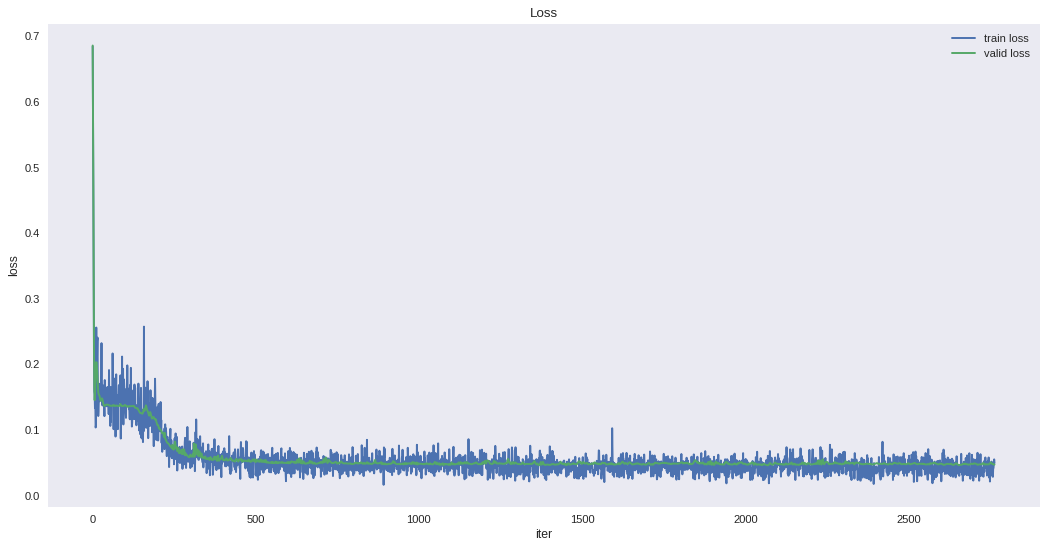

In [38]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

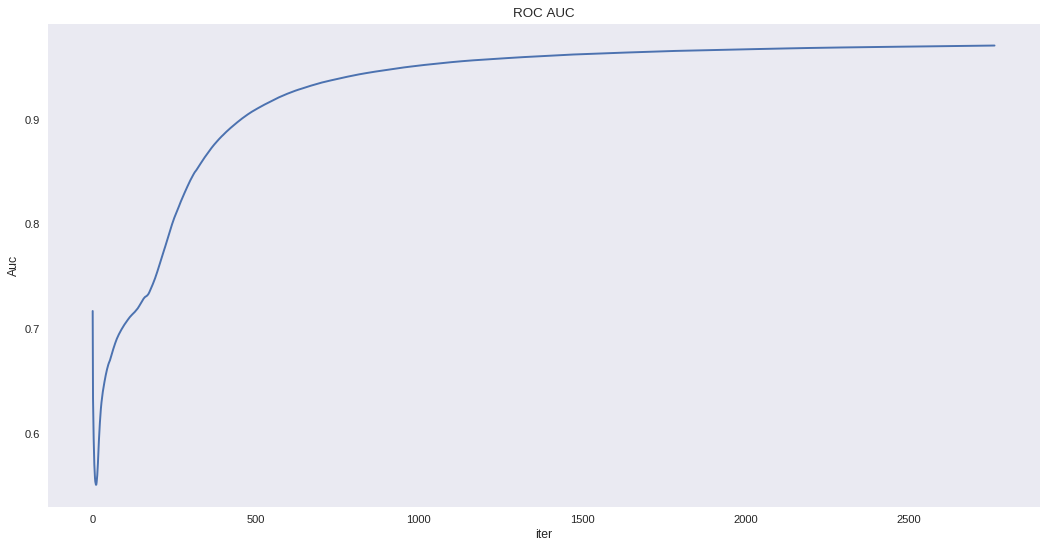

In [39]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_roc)
plt.title("ROC AUC")
plt.xlabel("iter")
plt.ylabel("Auc")
plt.grid()
plt.show()

In [0]:
del(comments_train, sentiments_train, seq_length_train, comments_validation, sentiments_validation, seq_length_validation)

In [41]:
with tf.Session() as sess:  
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = len(test_id)
    k = 40
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_id)
            
        

        # feed dictionary for the fold
        feed_dict_test =  {X:sequence_generator(comments_test[start:end], max_length, size),
                            length:seq_length_test[start:end],
                            keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = logits.eval(session=sess, feed_dict = feed_dict_test)
        if i == 0:
            preds  = fold_preds
        else:
            preds = np.append(preds, fold_preds, axis=0)
        
        print("Computed predictions for fold",i)
        
    del(model, comments_test, seq_length_test)
    
    submission_matrix = np.append(np.transpose([test_id]), preds, axis=1)
    del(test_id)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    submission = pd.DataFrame(submission_matrix, columns= columns)
    del(submission_matrix)
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-2762
Computed predictions for fold 0
Computed predictions for fold 1
Computed predictions for fold 2
Computed predictions for fold 3
Computed predictions for fold 4
Computed predictions for fold 5
Computed predictions for fold 6
Computed predictions for fold 7
Computed predictions for fold 8
Computed predictions for fold 9
Computed predictions for fold 10
Computed predictions for fold 11
Computed predictions for fold 12
Computed predictions for fold 13
Computed predictions for fold 14
Computed predictions for fold 15
Computed predictions for fold 16
Computed predictions for fold 17
Computed predictions for fold 18
Computed predictions for fold 19
Computed predictions for fold 20
Computed predictions for fold 21
Computed predictions for fold 22
Computed predictions for fold 23
Computed predictions for fold 24
Computed predictions for fold 25
Computed predictions for fold 26
Computed predictions for fold 27
Computed predictions for fol

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["download_folder2_id"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()